## Start Point

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from mplsoccer import PyPizza
import matplotlib.pyplot as plt

# === Step 1: Load your CSV ===
df = pd.read_csv("data.csv")

# === Step 2: Define refined metrics by category ===
metric_categories = {
    "Team Challenges Won": "Outplay",
    "Team Challenges Played": "Outplay",
    "Ind Challenges Won": "Outplay",

    "Idols Found": "Outwit",
    "Idols Played": "Outwit",
    "Succesful Idols Played": "Outwit",
    "Votes Voided": "Outwit",
    "VFB": "Outwit",

    "Tribals": "Outlast",
    "VAP": "Outlast",
    "Jury Votes Received": "Outlast",
}

# === Step 3: Calculate derived metrics before normalization ===
# Calculate Ind Challenge Win Rate
df["Ind Challenge Win Rate"] = df["Ind Challenges Won"] / df["Ind Challenges Played"].replace(0, 1)

# Normalize Jury Votes by Total Jurors
df["Jury Vote %"] = df["Jury Votes Received"] / df["Total Jurors"].replace(0, 1)

# Calculate Team Challenge Participation Rate
team_total = df["Team Challenges Played"] + df["Team Challenges Sat Out"]
df["Team Challenge Participation"] = df["Team Challenges Played"] / team_total.replace(0, 1)

# Add these derived metrics to our categories
df["Team Challenge Participation"] = df["Team Challenge Participation"].fillna(0)
df["Jury Vote %"] = df["Jury Vote %"].fillna(0)
df["Ind Challenge Win Rate"] = df["Ind Challenge Win Rate"].fillna(0)

# Refined metric list for normalization
refined_metrics = [
    "Team Challenges Won",
    "Team Challenge Participation",
    "Ind Challenge Win Rate",
    "Idols Found",
    "Idols Played",
    "Succesful Idols Played",
    "Votes Voided",
    "VFB",
    "Tribals",
    "VAP",
    "Jury Vote %"
]

# Map categories for derived metrics
metric_categories.update({
    "Team Challenge Participation": "Outplay",
    "Ind Challenge Win Rate": "Outplay",
    "Jury Vote %": "Outlast"
})

# === Step 4: Normalize ===
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[refined_metrics]), columns=refined_metrics)
df_scaled["Sole Survivor"] = df["Sole Survivor"]

# === Step 5: Melt ===
df_melted = df_scaled.melt(
    id_vars="Sole Survivor",
    var_name="Metric",
    value_name="Normalized Score"
)
df_melted["Category"] = df_melted["Metric"].map(metric_categories)

# === Step 5.5: Create Metric Name Aliases (for cleaner labels) ===
metric_aliases = {
    "Team Challenges Won": "Team Wins",
    "Team Challenge Participation": "Team Participation",
    "Ind Challenge Win Rate": "Ind. Win Rate",
    "Idols Found": "Idols Found",
    "Idols Played": "Idols Played",
    "Succesful Idols Played": "Successful Idols",
    "Votes Voided": "Votes Voided",
    "VFB": "Voted For Boot",
    "Tribals": "Tribals Attended",
    "VAP": "Votes Against",
    "Jury Vote %": "Jury Vote %"
}


# === Step 6: Plotting Function ===
def plot_pizza(survivor_name):
    data = df_melted[df_melted["Sole Survivor"] == survivor_name]
    #params = data["Metric"].tolist()
    params = [metric_aliases.get(m, m) for m in data["Metric"].tolist()]
    values = (data["Normalized Score"] * 100).tolist()
    categories = data["Category"].tolist()

    # Color map
    
    color_map = {
        "Outwit": "#9dbcd4",
        "Outplay": "#a6d1b3",
        "Outlast": "#f4a582"
    }
    slice_colors = [color_map[cat] for cat in categories]

    # Make pizza
    baker = PyPizza(params=params, max_range=100)
    fig, ax = baker.make_pizza(
        values,
        slice_colors=slice_colors,
        value_colors=["#000000"] * len(values),
        value_bck_colors=slice_colors,
        figsize=(7, 7),
        kwargs_values={"fontsize": 0},  # Effectively hides labels
    )

    # Adjust layout to move pizza down
    plt.subplots_adjust(top=0.85)
    plt.suptitle(survivor_name, fontsize=18, y=1.01)

    # Add custom legend
    handles = [
        plt.Line2D([0], [0], color=color_map[cat], lw=6, label=cat)
        for cat in color_map
    ]
    ax.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, 1.14), ncol=3, frameon=False)
    
    plt.show()

# Example
plot_pizza("Jericho Malabonga")

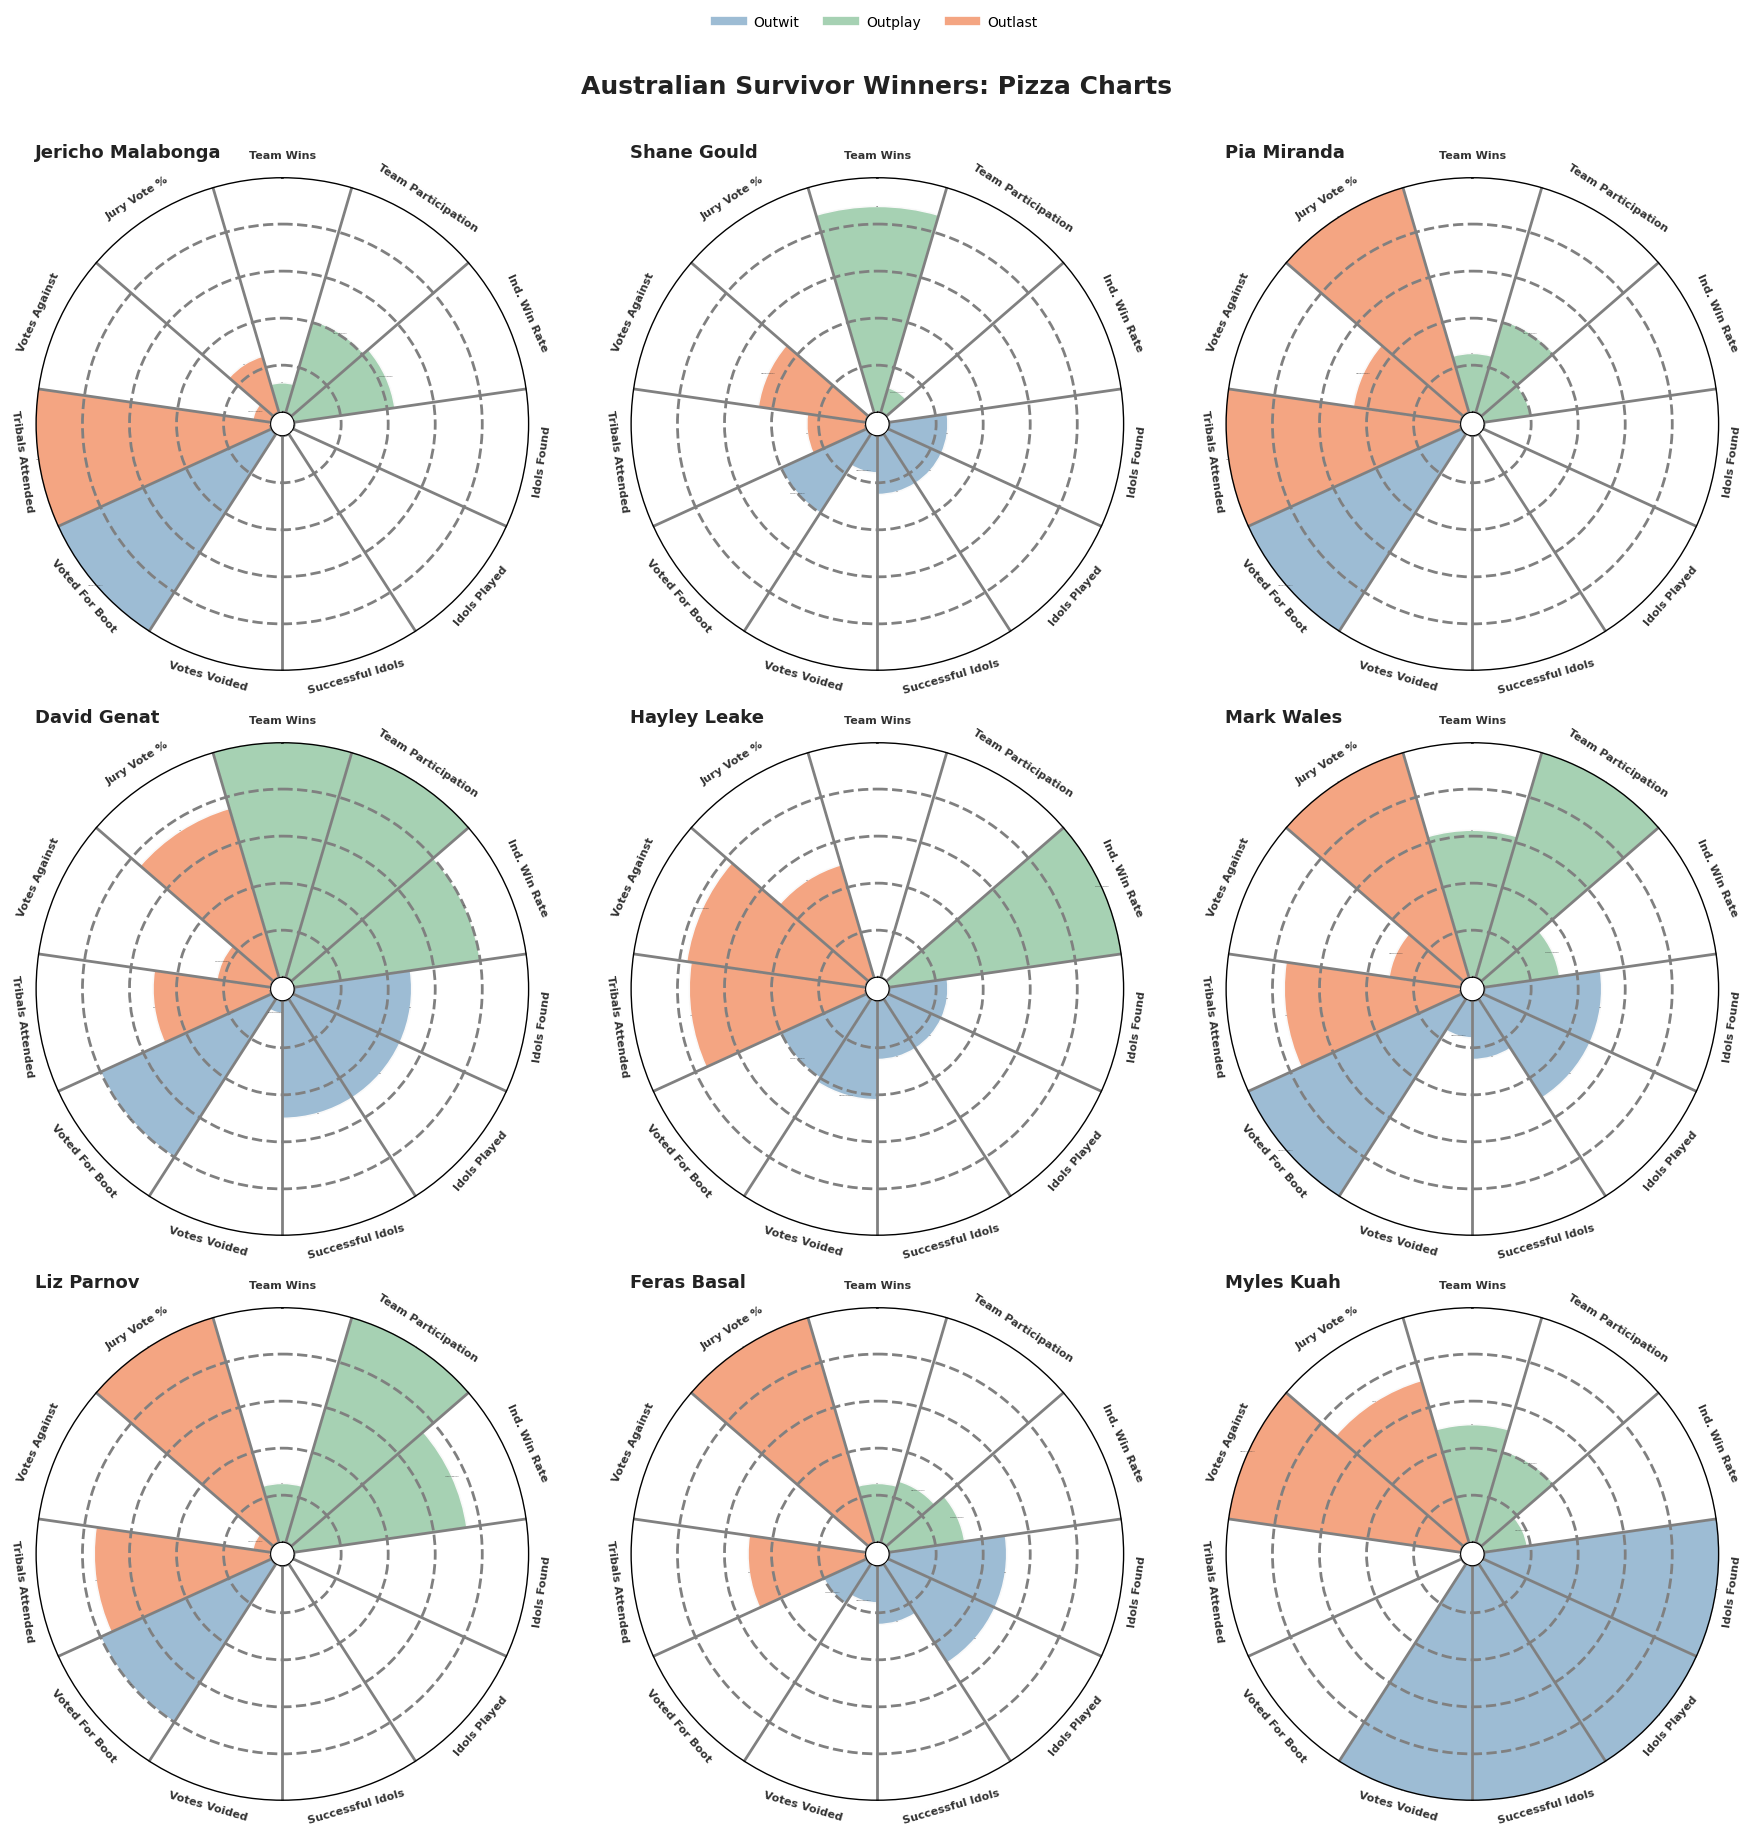

In [84]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from mplsoccer import PyPizza
import matplotlib.pyplot as plt

# === Step 1: Load your CSV ===
df = pd.read_csv("data.csv")

# === Step 2: Define refined metrics by category ===
metric_categories = {
    "Team Challenges Won": "Outplay",
    "Team Challenges Played": "Outplay",
    "Ind Challenges Won": "Outplay",

    "Idols Found": "Outwit",
    "Idols Played": "Outwit",
    "Succesful Idols Played": "Outwit",
    "Votes Voided": "Outwit",
    "VFB": "Outwit",

    "Tribals": "Outlast",
    "VAP": "Outlast",
    "Jury Votes Received": "Outlast",
}

# === Step 3: Calculate derived metrics before normalization ===
df["Ind Challenge Win Rate"] = df["Ind Challenges Won"] / df["Ind Challenges Played"].replace(0, 1)
df["Jury Vote %"] = df["Jury Votes Received"] / df["Total Jurors"].replace(0, 1)
team_total = df["Team Challenges Played"] + df["Team Challenges Sat Out"]
df["Team Challenge Participation"] = df["Team Challenges Played"] / team_total.replace(0, 1)

# Fill NA values just in case
df["Team Challenge Participation"] = df["Team Challenge Participation"].fillna(0)
df["Jury Vote %"] = df["Jury Vote %"].fillna(0)
df["Ind Challenge Win Rate"] = df["Ind Challenge Win Rate"].fillna(0)

# === Step 4: Normalize ===
refined_metrics = [
    "Team Challenges Won",
    "Team Challenge Participation",
    "Ind Challenge Win Rate",
    "Idols Found",
    "Idols Played",
    "Succesful Idols Played",
    "Votes Voided",
    "VFB",
    "Tribals",
    "VAP",
    "Jury Vote %"
]

metric_categories.update({
    "Team Challenge Participation": "Outplay",
    "Ind Challenge Win Rate": "Outplay",
    "Jury Vote %": "Outlast"
})

scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[refined_metrics]), columns=refined_metrics)
df_scaled["Sole Survivor"] = df["Sole Survivor"]

# === Step 5: Melt ===
df_melted = df_scaled.melt(
    id_vars="Sole Survivor",
    var_name="Metric",
    value_name="Normalized Score"
)
df_melted["Category"] = df_melted["Metric"].map(metric_categories)

# === Step 5.5: Aliases for Display ===
metric_aliases = {
    "Team Challenges Won": "Team Wins",
    "Team Challenge Participation": "Team Participation",
    "Ind Challenge Win Rate": "Ind. Win Rate",
    "Idols Found": "Idols Found",
    "Idols Played": "Idols Played",
    "Succesful Idols Played": "Successful Idols",
    "Votes Voided": "Votes Voided",
    "VFB": "Voted For Boot",
    "Tribals": "Tribals Attended",
    "VAP": "Votes Against",
    "Jury Vote %": "Jury Vote %"
}

# === Step 6: Plotting Function ===
def plot_pizza(survivor_name):
    data = df_melted[df_melted["Sole Survivor"] == survivor_name]
    params = [metric_aliases.get(m, m) for m in data["Metric"].tolist()]
    values = (data["Normalized Score"] * 100).tolist()
    categories = data["Category"].tolist()

    color_map = {
        "Outwit": "#9dbcd4",
        "Outplay": "#a6d1b3",
        "Outlast": "#f4a582"
    }
    slice_colors = [color_map[cat] for cat in categories]

    baker = PyPizza(params=params, max_range=100)
    fig, ax = baker.make_pizza(
        values,
        slice_colors=slice_colors,
        value_colors=["#333333"] * len(values),
        value_bck_colors=slice_colors,
        figsize=(7.5, 7.5),
        kwargs_slices={"edgecolor": "#f9f9f9", "linewidth": 1.2},
        kwargs_params={"fontsize": 10, "color": "#333333", "fontweight": "bold"},
        kwargs_values={"fontsize": 9, "color": "#333333"}
    )

    plt.subplots_adjust(top=0.85)
    plt.suptitle(survivor_name, fontsize=20, y=1.03, fontweight="bold", color="#222222")

    handles = [
        plt.Line2D([0], [0], color=color_map[cat], lw=6, label=cat)
        for cat in color_map
    ]
    ax.legend(
        handles=handles,
        loc='upper center',
        bbox_to_anchor=(0.5, 1.12),
        ncol=3,
        frameon=False,
        fontsize=9
    )

    plt.show()

# === Step 7: Plot All Winners in a Grid ===
def plot_all_pizzas():
    winners = df_scaled["Sole Survivor"].unique()
    num_winners = len(winners)
    cols = 3
    rows = (num_winners + cols - 1) // cols

    fig, axs = plt.subplots(rows, cols, subplot_kw={'polar': True}, figsize=(cols * 6, rows * 6))
    axs = axs.flatten()

    color_map = {
        "Outwit": "#9dbcd4",
        "Outplay": "#a6d1b3",
        "Outlast": "#f4a582"
    }

    for idx, winner in enumerate(winners):
        ax = axs[idx]
        data = df_melted[df_melted["Sole Survivor"] == winner]
        params = [metric_aliases.get(m, m) for m in data["Metric"].tolist()]
        values = (data["Normalized Score"] * 100).tolist()
        categories = data["Category"].tolist()
        slice_colors = [color_map[cat] for cat in categories]

        baker = PyPizza(params=params, max_range=100)
        baker.make_pizza(
            values,
            ax=ax,
            slice_colors=slice_colors,
            value_colors=["#333333"] * len(values),
            value_bck_colors=slice_colors,
            kwargs_slices={"edgecolor": "#f9f9f9", "linewidth": 1.1},
            kwargs_params={"fontsize": 8, "color": "#333333", "fontweight": "bold"},
            #kwargs_values={"fontsize": 7, "color": "#333333"}
            kwargs_values={"fontsize": 0},  # Effectively hides labels
        )
        ax.set_title(winner, fontsize=13, fontweight="bold", color="#222222", pad=14, loc="left")

    for i in range(len(winners), len(axs)):
        fig.delaxes(axs[i])

    handles = [plt.Line2D([0], [0], color=color_map[cat], lw=6, label=cat) for cat in color_map]
    fig.legend(handles=handles, loc="upper center", bbox_to_anchor=(0.5, 1.02), ncol=3, frameon=False, fontsize=10)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.suptitle("Australian Survivor Winners: Pizza Charts", fontsize=18, fontweight="bold", color="#222222")
    plt.show()

# === Optional: Export for Streamlit ===
#df_melted.to_csv("normalized_survivor_data.csv", index=False)

# Example
# plot_pizza("Jericho Malabonga")
plot_all_pizzas()

## Basic 2

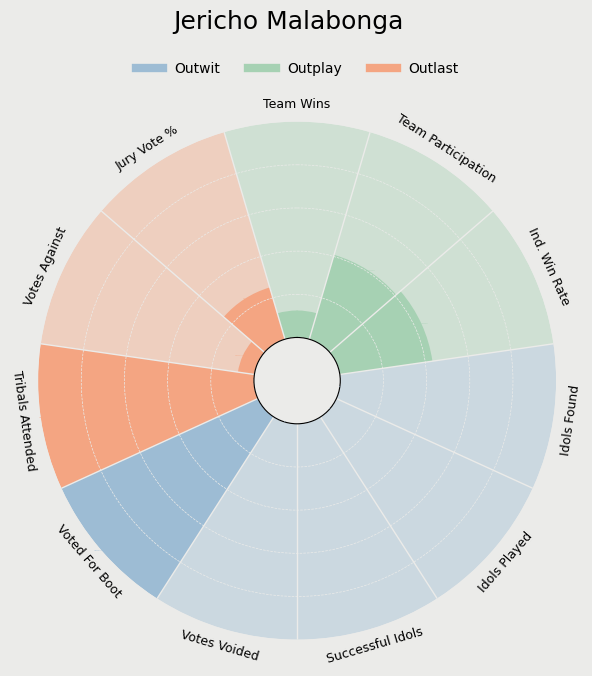

In [30]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from mplsoccer import PyPizza
import matplotlib.pyplot as plt

# === Step 1: Load your CSV ===
df = pd.read_csv("data.csv")

# === Step 2: Define refined metrics by category ===
metric_categories = {
    "Team Challenges Won": "Outplay",
    "Team Challenges Played": "Outplay",
    "Ind Challenges Won": "Outplay",

    "Idols Found": "Outwit",
    "Idols Played": "Outwit",
    "Succesful Idols Played": "Outwit",
    "Votes Voided": "Outwit",
    "VFB": "Outwit",

    "Tribals": "Outlast",
    "VAP": "Outlast",
    "Jury Votes Received": "Outlast",
}

# === Step 3: Calculate derived metrics before normalization ===
# Calculate Ind Challenge Win Rate
df["Ind Challenge Win Rate"] = df["Ind Challenges Won"] / df["Ind Challenges Played"].replace(0, 1)

# Normalize Jury Votes by Total Jurors
df["Jury Vote %"] = df["Jury Votes Received"] / df["Total Jurors"].replace(0, 1)

# Calculate Team Challenge Participation Rate
team_total = df["Team Challenges Played"] + df["Team Challenges Sat Out"]
df["Team Challenge Participation"] = df["Team Challenges Played"] / team_total.replace(0, 1)

# Add these derived metrics to our categories
df["Team Challenge Participation"] = df["Team Challenge Participation"].fillna(0)
df["Jury Vote %"] = df["Jury Vote %"].fillna(0)
df["Ind Challenge Win Rate"] = df["Ind Challenge Win Rate"].fillna(0)

# Refined metric list for normalization
refined_metrics = [
    "Team Challenges Won",
    "Team Challenge Participation",
    "Ind Challenge Win Rate",
    "Idols Found",
    "Idols Played",
    "Succesful Idols Played",
    "Votes Voided",
    "VFB",
    "Tribals",
    "VAP",
    "Jury Vote %"
]

# Map categories for derived metrics
metric_categories.update({
    "Team Challenge Participation": "Outplay",
    "Ind Challenge Win Rate": "Outplay",
    "Jury Vote %": "Outlast"
})

# === Step 4: Normalize ===
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[refined_metrics]), columns=refined_metrics)
df_scaled["Sole Survivor"] = df["Sole Survivor"]

# === Step 5: Melt ===
df_melted = df_scaled.melt(
    id_vars="Sole Survivor",
    var_name="Metric",
    value_name="Normalized Score"
)
df_melted["Category"] = df_melted["Metric"].map(metric_categories)

# === Step 5.5: Create Metric Name Aliases (for cleaner labels) ===
metric_aliases = {
    "Team Challenges Won": "Team Wins",
    "Team Challenge Participation": "Team Participation",
    "Ind Challenge Win Rate": "Ind. Win Rate",
    "Idols Found": "Idols Found",
    "Idols Played": "Idols Played",
    "Succesful Idols Played": "Successful Idols",
    "Votes Voided": "Votes Voided",
    "VFB": "Voted For Boot",
    "Tribals": "Tribals Attended",
    "VAP": "Votes Against",
    "Jury Vote %": "Jury Vote %"
}


# === Step 6: Plotting Function ===
def plot_pizza(survivor_name):
    data = df_melted[df_melted["Sole Survivor"] == survivor_name]
    #params = data["Metric"].tolist()
    params = [metric_aliases.get(m, m) for m in data["Metric"].tolist()]
    values = (data["Normalized Score"] * 100).tolist()
    categories = data["Category"].tolist()

    # Color map
    
    color_map = {
        "Outwit": "#9dbcd4",
        "Outplay": "#a6d1b3",
        "Outlast": "#f4a582"
    }
    slice_colors = [color_map[cat] for cat in categories]

    # Make pizza
    baker = PyPizza(
                params=params,                  # list of parameters
                background_color="#EBEBE9",     # background color
                straight_line_color="#EBEBE9",  # color for straight lines
                straight_line_lw=1,             # linewidth for straight lines
                last_circle_lw=0,               # linewidth of last circle
                other_circle_lw=0.5,              # linewidth for other circles
                inner_circle_size=20,           # size of inner circle
                other_circle_color="#EBEBE9",
                max_range=100,
            )

    
    fig, ax = baker.make_pizza(
        values,
        slice_colors=slice_colors,
        #value_colors=["#000000"] * len(values),
        value_bck_colors=slice_colors,
        figsize=(7, 7),
        kwargs_values={"fontsize": 0},  # Effectively hides labels
        color_blank_space="same",        # use same color to fill blank space
        #slice_colors=slice_colors,       # color for individual slices
        #value_colors=text_colors,        # color for the value-text
        value_colors=slice_colors,        # color for the value-text
        #value_bck_colors=slice_colors,   # color for the blank spaces
        blank_alpha=0.4,                 # alpha for blank-space colors
        #kwargs_slices=dict(
        #  edgecolor="#F2F2F2", zorder=2, linewidth=1
        #)
        #,                               # values to be used when plotting slices
        kwargs_params=dict(
        color="#000000", fontsize=9,
        va="center"
        )
    )

    # Adjust layout to move pizza down
    plt.subplots_adjust(top=0.85)
    plt.suptitle(survivor_name, fontsize=18, y=1.01)

    # Add custom legend
    handles = [
        plt.Line2D([0], [0], color=color_map[cat], lw=6, label=cat)
        for cat in color_map
    ]
    ax.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, 1.14), ncol=3, frameon=False)
    
    plt.show()

# Example
plot_pizza("Jericho Malabonga")

## White Version

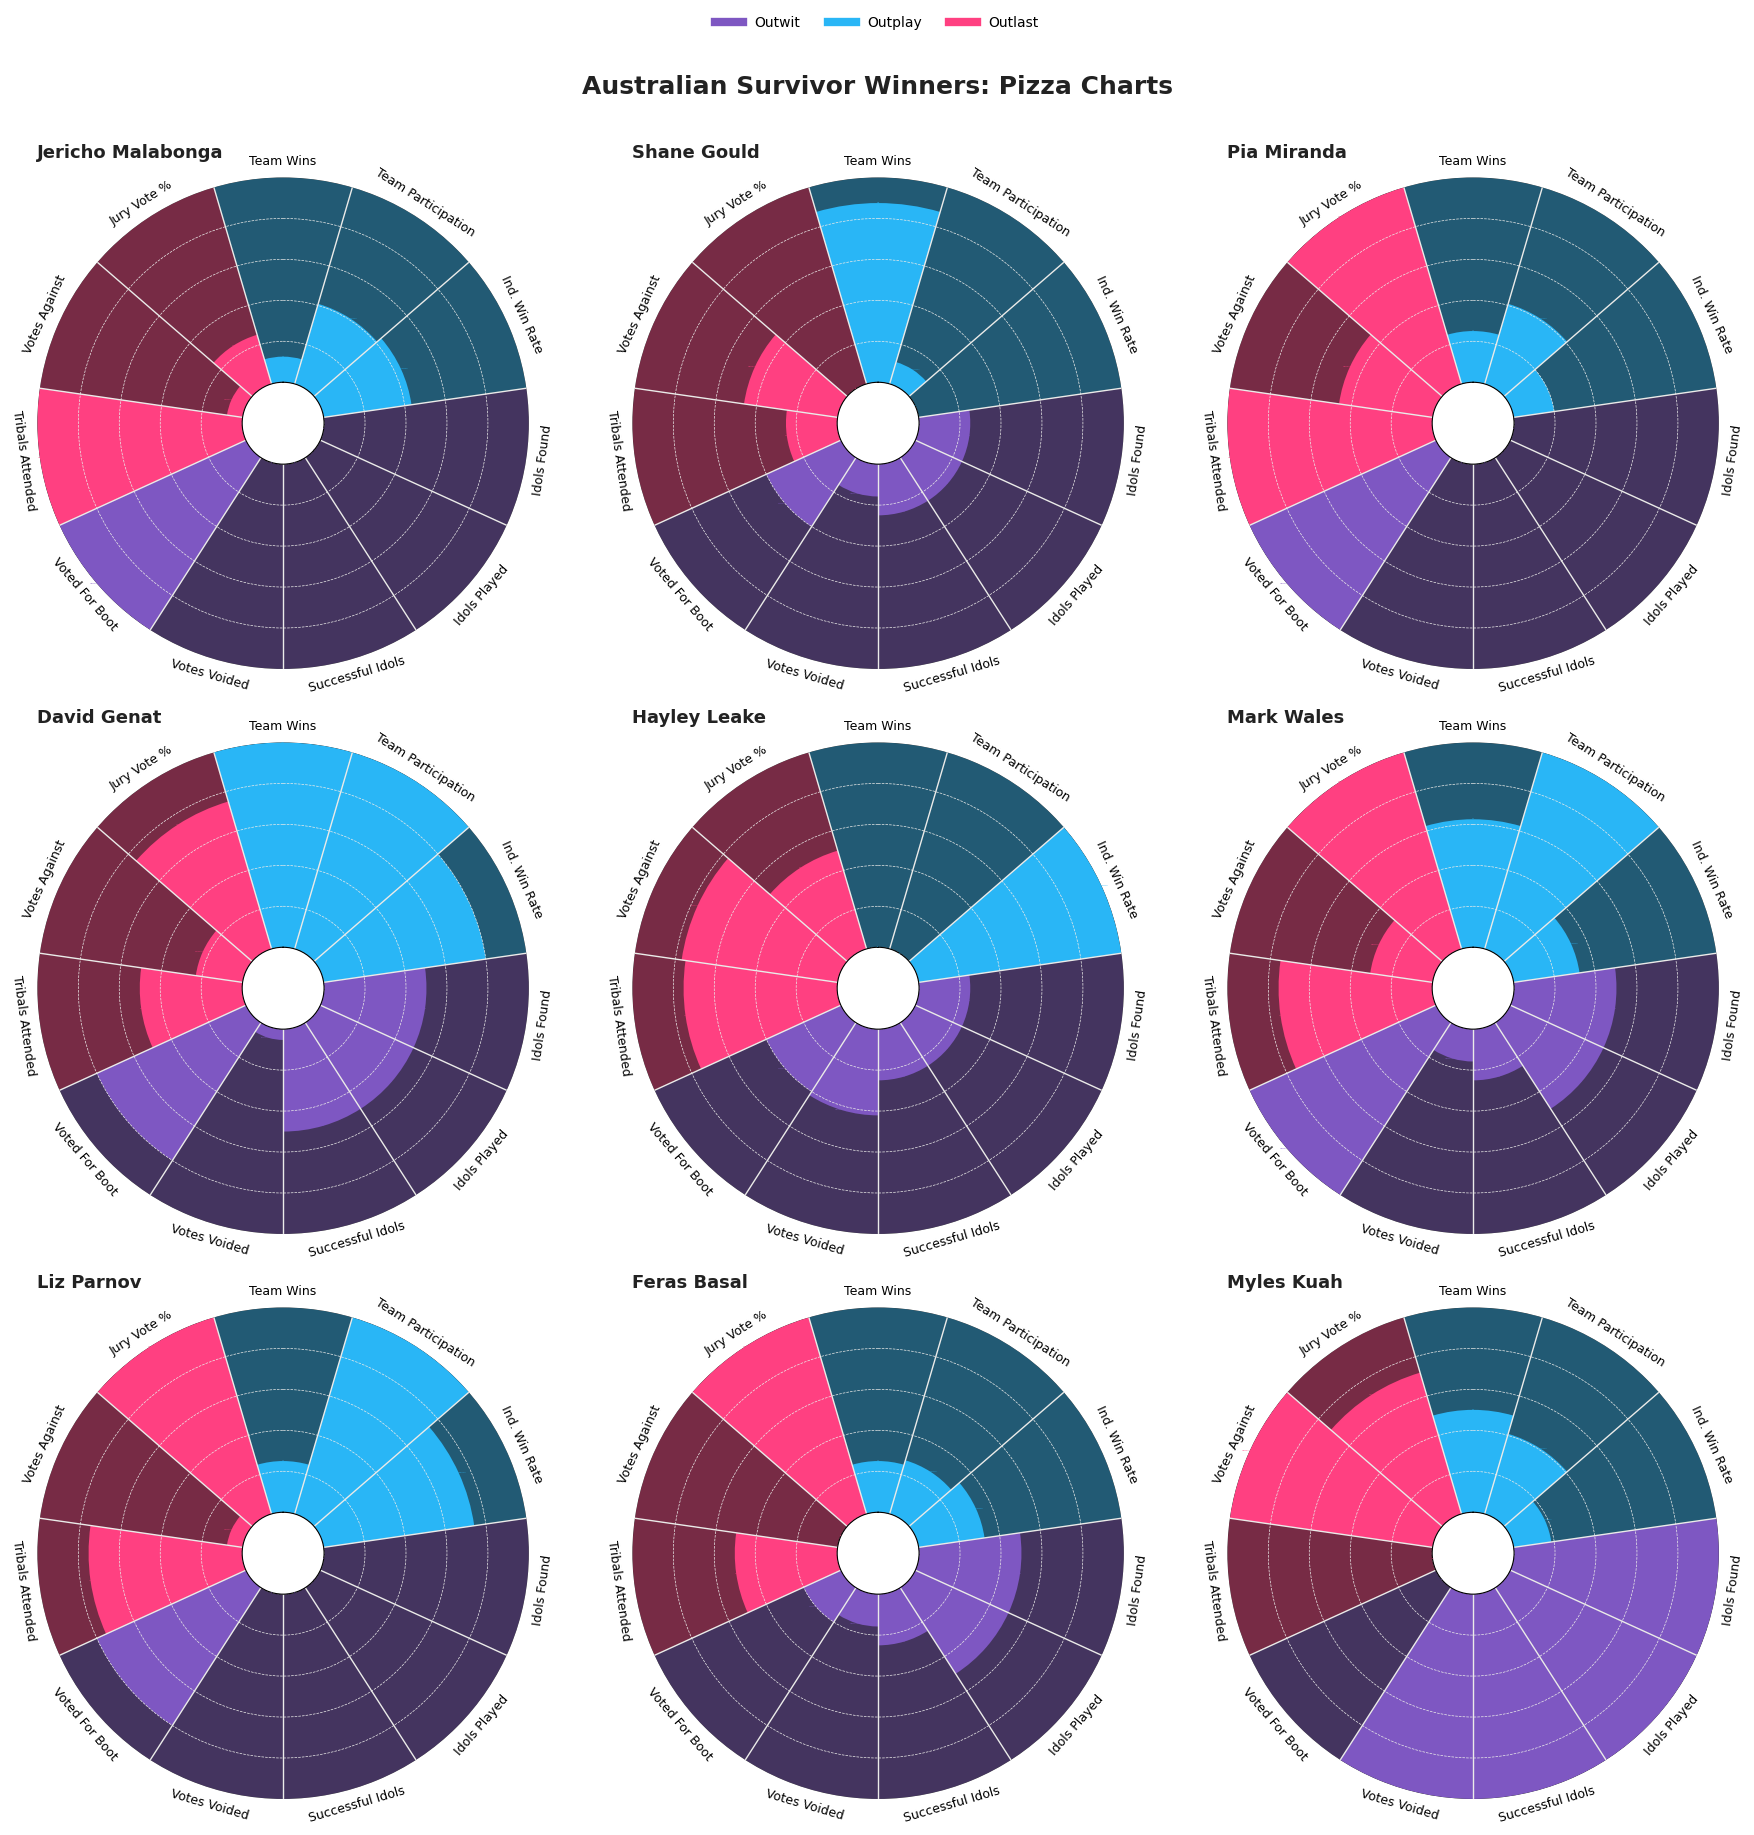

In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from mplsoccer import PyPizza
import matplotlib.pyplot as plt

# === Step 1: Load your CSV ===
df = pd.read_csv("data.csv")

# === Step 2: Define refined metrics by category ===
metric_categories = {
    "Team Challenges Won": "Outplay",
    "Team Challenges Played": "Outplay",
    "Ind Challenges Won": "Outplay",

    "Idols Found": "Outwit",
    "Idols Played": "Outwit",
    "Succesful Idols Played": "Outwit",
    "Votes Voided": "Outwit",
    "VFB": "Outwit",

    "Tribals": "Outlast",
    "VAP": "Outlast",
    "Jury Votes Received": "Outlast",
}

# === Step 3: Calculate derived metrics before normalization ===
df["Ind Challenge Win Rate"] = df["Ind Challenges Won"] / df["Ind Challenges Played"].replace(0, 1)
df["Jury Vote %"] = df["Jury Votes Received"] / df["Total Jurors"].replace(0, 1)
team_total = df["Team Challenges Played"] + df["Team Challenges Sat Out"]
df["Team Challenge Participation"] = df["Team Challenges Played"] / team_total.replace(0, 1)

# Fill NA values just in case
df["Team Challenge Participation"] = df["Team Challenge Participation"].fillna(0)
df["Jury Vote %"] = df["Jury Vote %"].fillna(0)
df["Ind Challenge Win Rate"] = df["Ind Challenge Win Rate"].fillna(0)

# === Step 4: Normalize ===
refined_metrics = [
    "Team Challenges Won",
    "Team Challenge Participation",
    "Ind Challenge Win Rate",
    "Idols Found",
    "Idols Played",
    "Succesful Idols Played",
    "Votes Voided",
    "VFB",
    "Tribals",
    "VAP",
    "Jury Vote %"
]

metric_categories.update({
    "Team Challenge Participation": "Outplay",
    "Ind Challenge Win Rate": "Outplay",
    "Jury Vote %": "Outlast"
})

scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[refined_metrics]), columns=refined_metrics)
df_scaled["Sole Survivor"] = df["Sole Survivor"]

# === Step 5: Melt ===
df_melted = df_scaled.melt(
    id_vars="Sole Survivor",
    var_name="Metric",
    value_name="Normalized Score"
)
df_melted["Category"] = df_melted["Metric"].map(metric_categories)

# === Step 5.5: Aliases for Display ===
metric_aliases = {
    "Team Challenges Won": "Team Wins",
    "Team Challenge Participation": "Team Participation",
    "Ind Challenge Win Rate": "Ind. Win Rate",
    "Idols Found": "Idols Found",
    "Idols Played": "Idols Played",
    "Succesful Idols Played": "Successful Idols",
    "Votes Voided": "Votes Voided",
    "VFB": "Voted For Boot",
    "Tribals": "Tribals Attended",
    "VAP": "Votes Against",
    "Jury Vote %": "Jury Vote %"
}

# === Step 6: Plotting Function ===
def plot_pizza(survivor_name):
    data = df_melted[df_melted["Sole Survivor"] == survivor_name]
    params = [metric_aliases.get(m, m) for m in data["Metric"].tolist()]
    values = (data["Normalized Score"] * 100).tolist()
    categories = data["Category"].tolist()

    color_map = {
        "Outwit": "#B2B09B",   # muted olive
        "Outplay": "#8CBEB2",  # dusty turquoise
        "Outlast": "#F2B880"   # warm tan
    }

    slice_colors = [color_map[cat] for cat in categories]

    baker = PyPizza(
                params=params,                  # list of parameters
                background_color="#EBEBE9",     # background color
                straight_line_color="#EBEBE9",  # color for straight lines
                straight_line_lw=1,             # linewidth for straight lines
                last_circle_lw=0,               # linewidth of last circle
                other_circle_lw=0.5,              # linewidth for other circles
                inner_circle_size=20,           # size of inner circle
                other_circle_color="#EBEBE9",
                max_range=100,
            )

    
    fig, ax = baker.make_pizza(
        values,
        slice_colors=slice_colors,
        #value_colors=["#000000"] * len(values),
        value_bck_colors=slice_colors,
        figsize=(7, 7),
        kwargs_values={"fontsize": 0},  # Effectively hides labels
        color_blank_space="same",        # use same color to fill blank space
        #slice_colors=slice_colors,       # color for individual slices
        #value_colors=text_colors,        # color for the value-text
        value_colors=slice_colors,        # color for the value-text
        #value_bck_colors=slice_colors,   # color for the blank spaces
        blank_alpha=0.4,                 # alpha for blank-space colors
        #kwargs_slices=dict(
        #  edgecolor="#F2F2F2", zorder=2, linewidth=1
        #)
        #,                               # values to be used when plotting slices
        kwargs_params=dict(
        color="#000000", fontsize=9,
        va="center"
        )
    )

    plt.subplots_adjust(top=0.85)
    plt.suptitle(survivor_name, fontsize=20, y=1.03, fontweight="bold", color="#222222")

    handles = [
        plt.Line2D([0], [0], color=color_map[cat], lw=6, label=cat)
        for cat in color_map
    ]
    ax.legend(
        handles=handles,
        loc='upper center',
        bbox_to_anchor=(0.5, 1.12),
        ncol=3,
        frameon=False,
        fontsize=9
    )

    plt.show()

# === Step 7: Plot All Winners in a Grid ===
def plot_all_pizzas():
    winners = df_scaled["Sole Survivor"].unique()
    num_winners = len(winners)
    cols = 3
    rows = (num_winners + cols - 1) // cols

    fig, axs = plt.subplots(rows, cols, subplot_kw={'projection': 'polar'}, figsize=(cols * 6, rows * 6))
    axs = axs.flatten()

    color_map = {
        "Outwit": "#7E57C2",   # violet purple
        "Outplay": "#29B6F6",  # neon blue
        "Outlast": "#FF4081"   # electric pink
    }


    for idx, winner in enumerate(winners):
        ax = axs[idx]
        data = df_melted[df_melted["Sole Survivor"] == winner]
        params = [metric_aliases.get(m, m) for m in data["Metric"].tolist()]
        values = (data["Normalized Score"] * 100).tolist()
        categories = data["Category"].tolist()
        slice_colors = [color_map[cat] for cat in categories]

        baker = PyPizza(
            params=params,
            background_color="#EBEBE9",
            straight_line_color="#EBEBE9",
            straight_line_lw=1,
            last_circle_lw=0,
            other_circle_lw=0.5,
            inner_circle_size=20,
            other_circle_color="#EBEBE9",
            max_range=100,
        )

        baker.make_pizza(
            values,
            ax=ax,  # 👈 ensure the correct subplot is used
            slice_colors=slice_colors,
            value_bck_colors=slice_colors,
            figsize=(7, 7),
            kwargs_values={"fontsize": 0},
            color_blank_space="same",
            value_colors=slice_colors,
            blank_alpha=0.4,
            kwargs_params=dict(
                color="#000000", fontsize=9, va="center"
            )
        )

        ax.set_title(winner, fontsize=13, fontweight="bold", color="#222222", pad=14, loc="left")

    # Remove any unused axes
    for i in range(len(winners), len(axs)):
        fig.delaxes(axs[i])

    # Add legend and suptitle
    handles = [plt.Line2D([0], [0], color=color_map[cat], lw=6, label=cat) for cat in color_map]
    fig.legend(handles=handles, loc="upper center", bbox_to_anchor=(0.5, 1.02), ncol=3, frameon=False, fontsize=10)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.suptitle("Australian Survivor Winners: Pizza Charts", fontsize=18, fontweight="bold", color="#222222")
    plt.show()



# === Optional: Export for Streamlit ===
#df_melted.to_csv("normalized_survivor_data.csv", index=False)

# Example
# plot_pizza("Jericho Malabonga")
plot_all_pizzas()

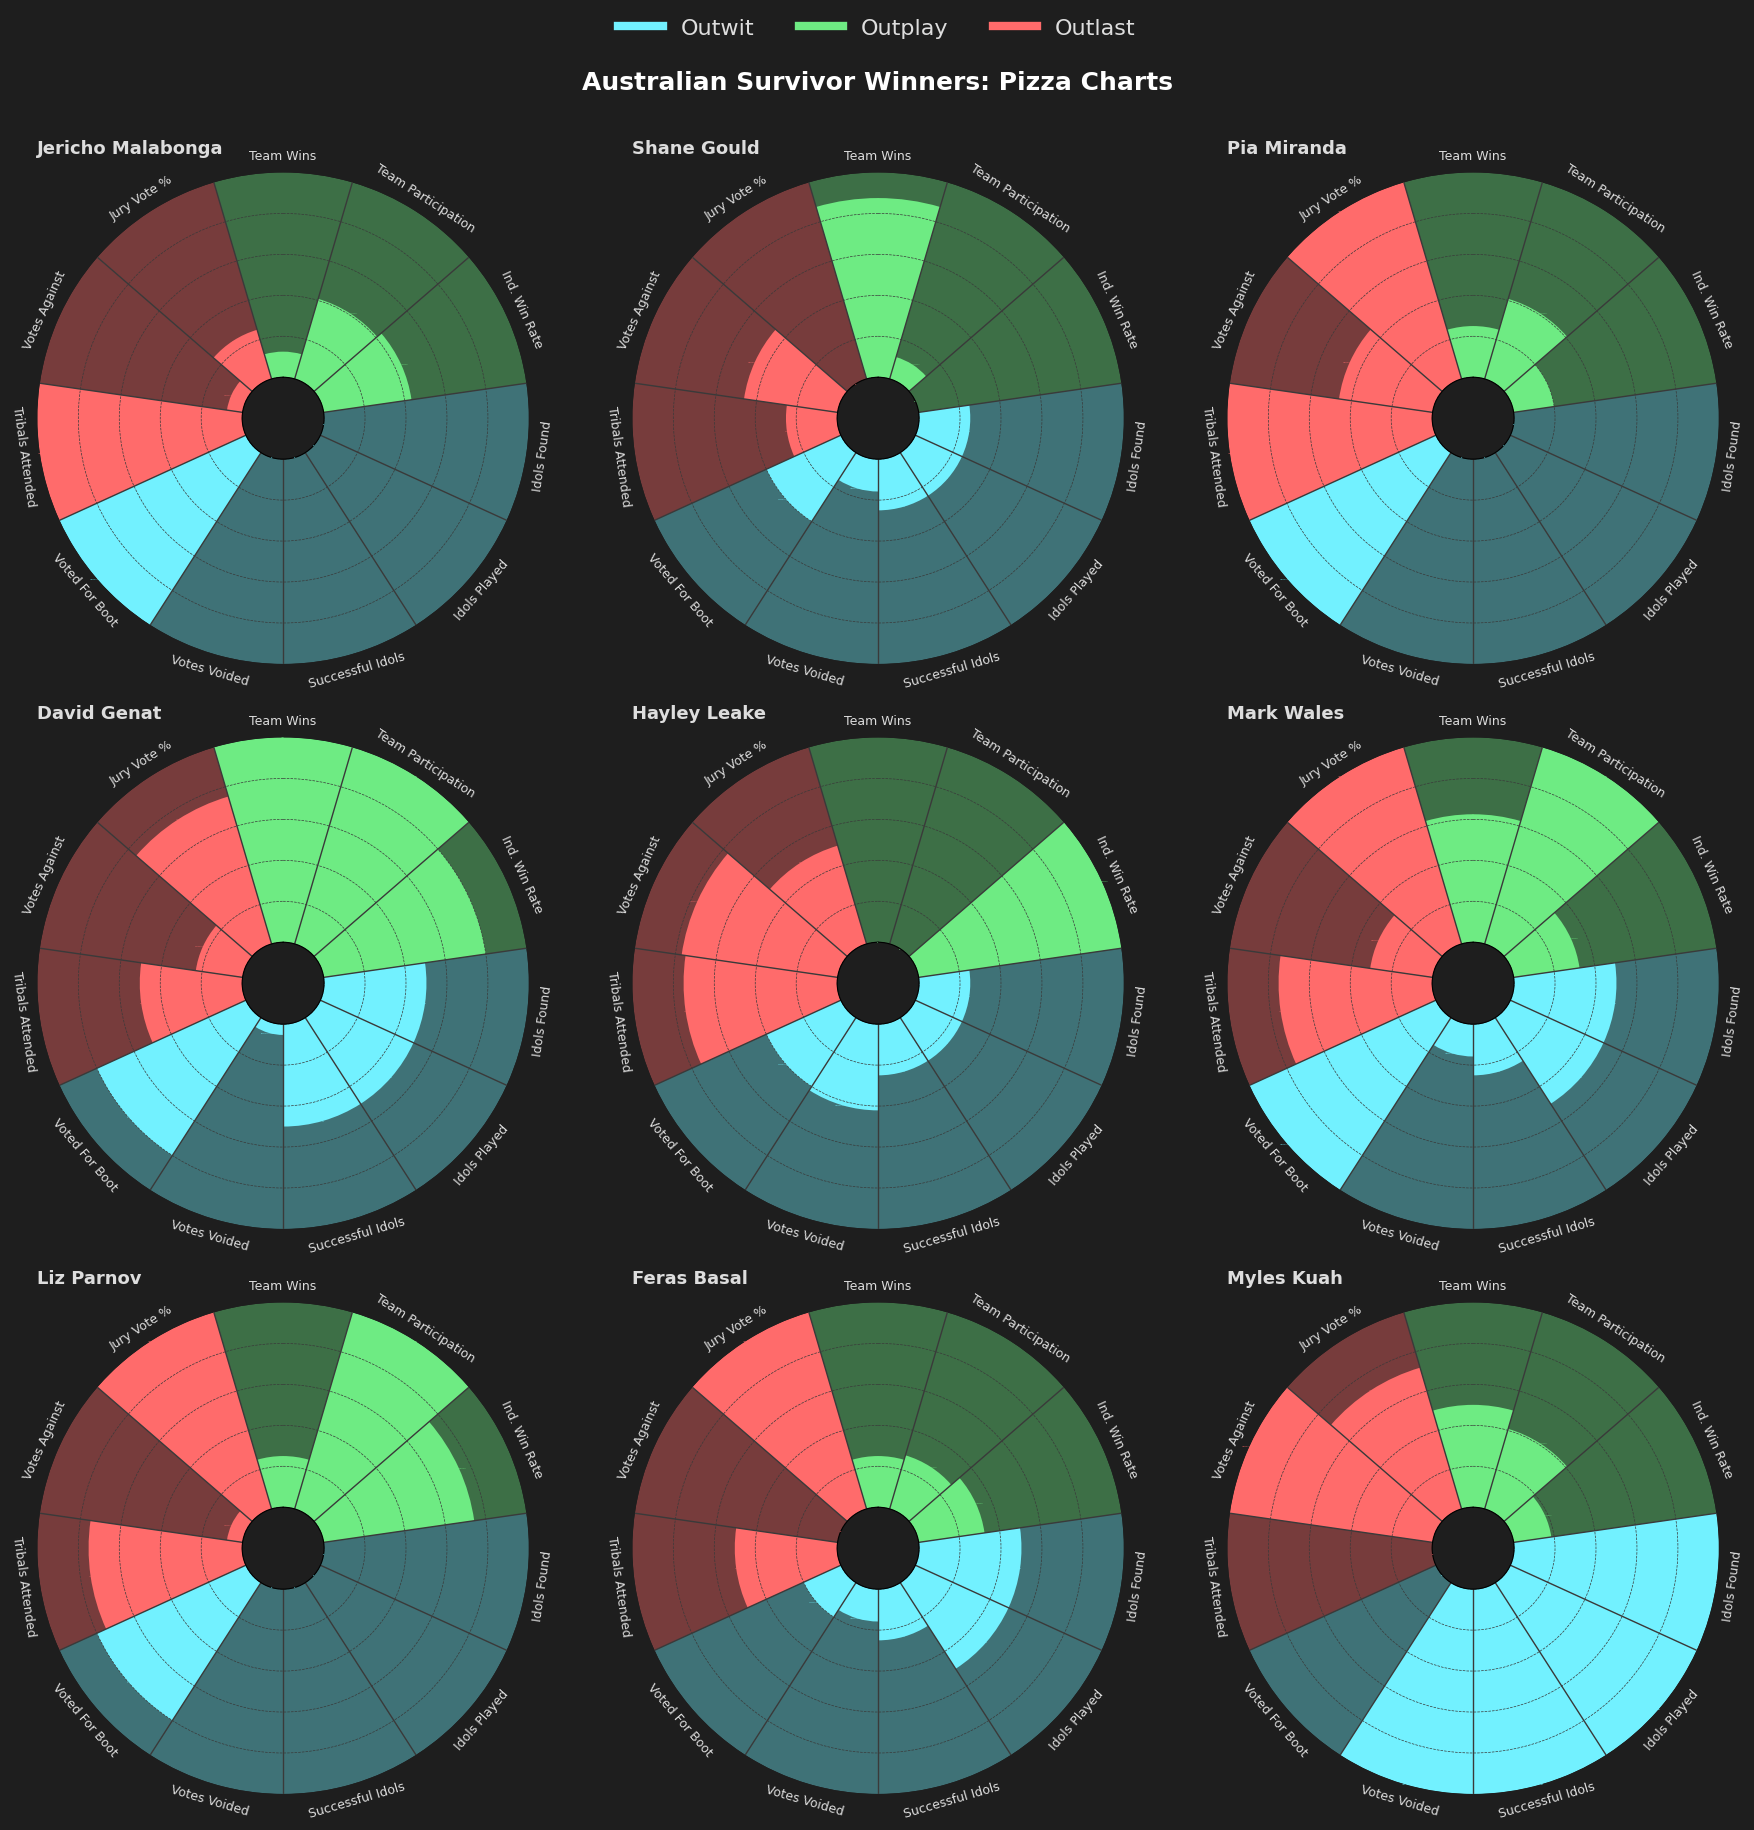

In [77]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from mplsoccer import PyPizza
import matplotlib.pyplot as plt

# === Step 1: Load your CSV ===
df = pd.read_csv("data.csv")

# === Step 2: Define refined metrics by category ===
metric_categories = {
    "Team Challenges Won": "Outplay",
    "Team Challenges Played": "Outplay",
    "Ind Challenges Won": "Outplay",

    "Idols Found": "Outwit",
    "Idols Played": "Outwit",
    "Succesful Idols Played": "Outwit",
    "Votes Voided": "Outwit",
    "VFB": "Outwit",

    "Tribals": "Outlast",
    "VAP": "Outlast",
    "Jury Votes Received": "Outlast",
}

# === Step 3: Calculate derived metrics before normalization ===
df["Ind Challenge Win Rate"] = df["Ind Challenges Won"] / df["Ind Challenges Played"].replace(0, 1)
df["Jury Vote %"] = df["Jury Votes Received"] / df["Total Jurors"].replace(0, 1)
team_total = df["Team Challenges Played"] + df["Team Challenges Sat Out"]
df["Team Challenge Participation"] = df["Team Challenges Played"] / team_total.replace(0, 1)

# Fill NA values just in case
df["Team Challenge Participation"] = df["Team Challenge Participation"].fillna(0)
df["Jury Vote %"] = df["Jury Vote %"].fillna(0)
df["Ind Challenge Win Rate"] = df["Ind Challenge Win Rate"].fillna(0)

# === Step 4: Normalize ===
refined_metrics = [
    "Team Challenges Won",
    "Team Challenge Participation",
    "Ind Challenge Win Rate",
    "Idols Found",
    "Idols Played",
    "Succesful Idols Played",
    "Votes Voided",
    "VFB",
    "Tribals",
    "VAP",
    "Jury Vote %"
]

metric_categories.update({
    "Team Challenge Participation": "Outplay",
    "Ind Challenge Win Rate": "Outplay",
    "Jury Vote %": "Outlast"
})

scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[refined_metrics]), columns=refined_metrics)
df_scaled["Sole Survivor"] = df["Sole Survivor"]

# === Step 5: Melt ===
df_melted = df_scaled.melt(
    id_vars="Sole Survivor",
    var_name="Metric",
    value_name="Normalized Score"
)
df_melted["Category"] = df_melted["Metric"].map(metric_categories)

# === Step 5.5: Aliases for Display ===
metric_aliases = {
    "Team Challenges Won": "Team Wins",
    "Team Challenge Participation": "Team Participation",
    "Ind Challenge Win Rate": "Ind. Win Rate",
    "Idols Found": "Idols Found",
    "Idols Played": "Idols Played",
    "Succesful Idols Played": "Successful Idols",
    "Votes Voided": "Votes Voided",
    "VFB": "Voted For Boot",
    "Tribals": "Tribals Attended",
    "VAP": "Votes Against",
    "Jury Vote %": "Jury Vote %"
}

# === Step 6: Plotting Function ===
def plot_pizza(survivor_name):
    data = df_melted[df_melted["Sole Survivor"] == survivor_name]
    params = [metric_aliases.get(m, m) for m in data["Metric"].tolist()]
    values = (data["Normalized Score"] * 100).tolist()
    categories = data["Category"].tolist()

    color_map = {
        "Outwit": "#7E57C2",   # violet purple
        "Outplay": "#29B6F6",  # neon blue
        "Outlast": "#FF4081"   # electric pink
    }

    slice_colors = [color_map[cat] for cat in categories]

    baker = PyPizza(
                params=params,                  # list of parameters
                background_color="#1E1E1E",   # charcoal matte background
                straight_line_color="#3A3A3A",  # darker grid lines
                other_circle_color="#3A3A3A",
                straight_line_lw=1,             # linewidth for straight lines
                last_circle_lw=0,               # linewidth of last circle
                other_circle_lw=0.5,              # linewidth for other circles
                inner_circle_size=20,           # size of inner circle

                max_range=100,
            )

    
    fig, ax = baker.make_pizza(
        values,
        slice_colors=slice_colors,
        #value_colors=["#000000"] * len(values),
        value_bck_colors=slice_colors,
        figsize=(7, 7),
        kwargs_values={"fontsize": 0},  # Effectively hides labels
        color_blank_space="same",        # use same color to fill blank space
        #slice_colors=slice_colors,       # color for individual slices
        #value_colors=text_colors,        # color for the value-text
        value_colors=slice_colors,        # color for the value-text
        #value_bck_colors=slice_colors,   # color for the blank spaces
        blank_alpha=0.4,                 # alpha for blank-space colors
        #kwargs_slices=dict(
        #  edgecolor="#F2F2F2", zorder=2, linewidth=1
        #)
        #,                               # values to be used when plotting slices
        kwargs_params=dict(
        color="#000000", fontsize=9,
        va="center"
        )
    )

    plt.subplots_adjust(top=0.85)
    plt.suptitle(survivor_name, fontsize=20, y=1.03, fontweight="bold", color="#222222")

    handles = [
        plt.Line2D([0], [0], color=color_map[cat], lw=6, label=cat)
        for cat in color_map
    ]
    ax.legend(
        handles=handles,
        loc='upper center',
        bbox_to_anchor=(0.5, 1.12),
        ncol=3,
        frameon=False,
        fontsize=9
    )

    plt.show()

# === Step 7: Plot All Winners in a Grid ===
def plot_all_pizzas():
    winners = df_scaled["Sole Survivor"].unique()
    num_winners = len(winners)
    cols = 3
    rows = (num_winners + cols - 1) // cols

    fig, axs = plt.subplots(rows, cols, subplot_kw={'projection': 'polar'}, figsize=(cols * 6, rows * 6))
    axs = axs.flatten()
    fig.patch.set_facecolor('#1E1E1E')  # Background of the whole figure
    for ax in axs:
        ax.set_facecolor('#1E1E1E')     # Background of each individual polar plot
    color_map = {
        "Outwit": "#72F1FF",   # electric cyan
        "Outplay": "#6EEB83",  # glowing green
        "Outlast": "#FF6B6B"   # coral red
    }

    for idx, winner in enumerate(winners):
        ax = axs[idx]
        data = df_melted[df_melted["Sole Survivor"] == winner]
        params = [metric_aliases.get(m, m) for m in data["Metric"].tolist()]
        values = (data["Normalized Score"] * 100).tolist()
        categories = data["Category"].tolist()
        slice_colors = [color_map[cat] for cat in categories]

        baker = PyPizza(
                    params=params,                  # list of parameters
                    background_color="#1E1E1E",   # charcoal matte background
                    straight_line_color="#3A3A3A",  # darker grid lines
                    other_circle_color="#3A3A3A",
                    straight_line_lw=1,             # linewidth for straight lines
                    last_circle_lw=0,               # linewidth of last circle
                    other_circle_lw=0.5,              # linewidth for other circles
                    inner_circle_size=20,           # size of inner circle
                    max_range=100,
                )

        baker.make_pizza(
            values,
            ax=ax,  # 👈 ensure the correct subplot is used
            slice_colors=slice_colors,
            value_bck_colors=slice_colors,
            figsize=(7, 7),
            kwargs_values={"fontsize": 0},
            color_blank_space="same",
            value_colors=slice_colors,
            blank_alpha=0.4,
            kwargs_params=dict(
                color="#DDDDDD", fontsize=9, va="center"
            )
        )

        ax.set_title(winner, fontsize=13, fontweight="bold", color="#DDDDDD", pad=14, loc="left")

    # Remove any unused axes
    for i in range(len(winners), len(axs)):
        fig.delaxes(axs[i])

    # Add legend and suptitle
    handles = [plt.Line2D([0], [0], color=color_map[cat], lw=6, label=cat) for cat in color_map]
    fig.legend(
        handles=handles,
        loc="upper center",
        bbox_to_anchor=(0.5, 1.02),
        ncol=3,
        frameon=False,
        fontsize=16,
        labelcolor="#DDDDDD"   # or "#FFFFFF" for pure white
    )

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.suptitle("Australian Survivor Winners: Pizza Charts", fontsize=18, fontweight="bold", color="#FFFFFF")
    plt.show()



# === Optional: Export for Streamlit ===
#df_melted.to_csv("normalized_survivor_data.csv", index=False)

# Example
# plot_pizza("Jericho Malabonga")
plot_all_pizzas()

In [ ]:
'''
    color_map = {
        "Outwit": "#7E57C2",   # violet purple
        "Outplay": "#29B6F6",  # neon blue
        "Outlast": "#FF4081"   # electric pink
    }
'''
color_map = {
    "Outwit": "#00F5D4",   # bright aqua
    "Outplay": "#9B5DE5",  # violet
    "Outlast": "#F15BB5"   # hot pink
}
color_map = {
    "Outwit": "#FFD700",   # rich gold
    "Outplay": "#6A0DAD",  # royal purple
    "Outlast": "#4682B4"   # steel blue
}
color_map = {
    "Outwit": "#72F1FF",   # electric cyan
    "Outplay": "#6EEB83",  # glowing green
    "Outlast": "#FF6B6B"   # coral red
}


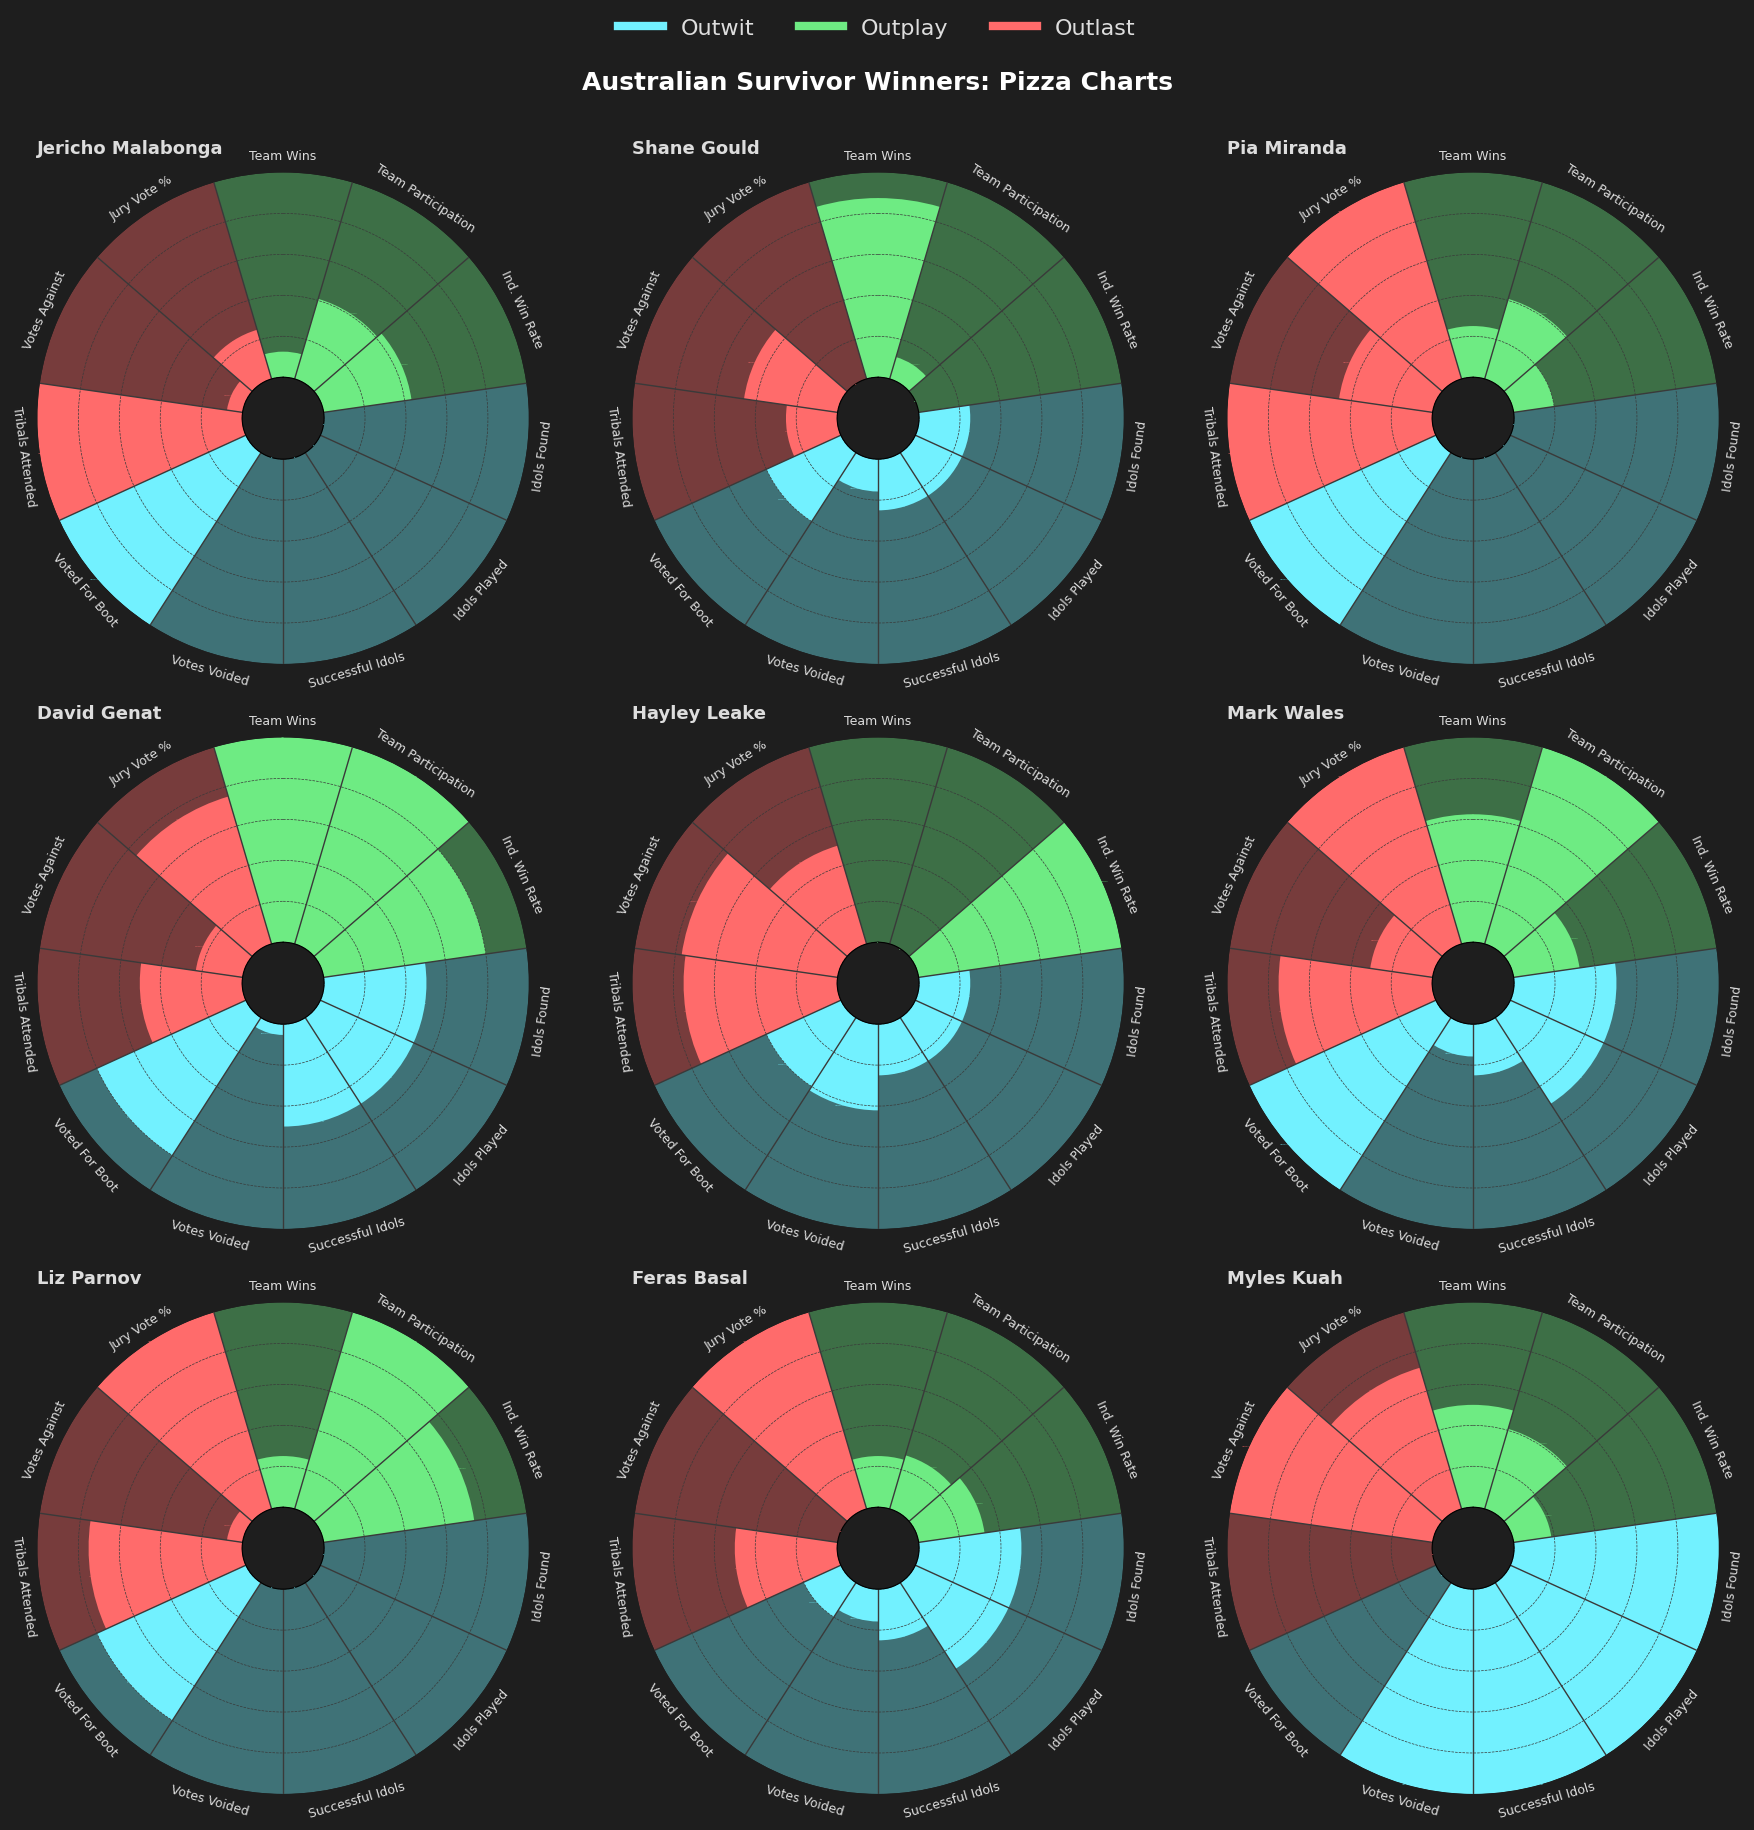

In [22]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from mplsoccer import PyPizza
import matplotlib.pyplot as plt

# === Step 1: Load your CSV ===
df = pd.read_csv("data.csv")

# === Step 2: Define refined metrics by category ===
metric_categories = {
    "Team Challenges Won": "Outplay",
    "Team Challenges Played": "Outplay",
    "Ind Challenges Won": "Outplay",

    "Idols Found": "Outwit",
    "Idols Played": "Outwit",
    "Succesful Idols Played": "Outwit",
    "Votes Voided": "Outwit",
    "VFB": "Outwit",

    "Tribals": "Outlast",
    "VAP": "Outlast",
    "Jury Votes Received": "Outlast",
}

# === Step 3: Calculate derived metrics before normalization ===
df["Ind Challenge Win Rate"] = df["Ind Challenges Won"] / df["Ind Challenges Played"].replace(0, 1)
df["Jury Vote %"] = df["Jury Votes Received"] / df["Total Jurors"].replace(0, 1)
team_total = df["Team Challenges Played"] + df["Team Challenges Sat Out"]
df["Team Challenge Participation"] = df["Team Challenges Played"] / team_total.replace(0, 1)

# Fill NA values just in case
df["Team Challenge Participation"] = df["Team Challenge Participation"].fillna(0)
df["Jury Vote %"] = df["Jury Vote %"].fillna(0)
df["Ind Challenge Win Rate"] = df["Ind Challenge Win Rate"].fillna(0)

# === Step 4: Normalize ===
refined_metrics = [
    "Team Challenges Won",
    "Team Challenge Participation",
    "Ind Challenge Win Rate",
    "Idols Found",
    "Idols Played",
    "Succesful Idols Played",
    "Votes Voided",
    "VFB",
    "Tribals",
    "VAP",
    "Jury Vote %"
]

metric_categories.update({
    "Team Challenge Participation": "Outplay",
    "Ind Challenge Win Rate": "Outplay",
    "Jury Vote %": "Outlast"
})

scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[refined_metrics]), columns=refined_metrics)
df_scaled["Sole Survivor"] = df["Sole Survivor"]

# === Step 5: Melt ===
df_melted = df_scaled.melt(
    id_vars="Sole Survivor",
    var_name="Metric",
    value_name="Normalized Score"
)
df_melted["Category"] = df_melted["Metric"].map(metric_categories)

# === Step 5.5: Aliases for Display ===
metric_aliases = {
    "Team Challenges Won": "Team Wins",
    "Team Challenge Participation": "Team Participation",
    "Ind Challenge Win Rate": "Ind. Win Rate",
    "Idols Found": "Idols Found",
    "Idols Played": "Idols Played",
    "Succesful Idols Played": "Successful Idols",
    "Votes Voided": "Votes Voided",
    "VFB": "Voted For Boot",
    "Tribals": "Tribals Attended",
    "VAP": "Votes Against",
    "Jury Vote %": "Jury Vote %"
}

# === Step 6: Plotting Function ===
def plot_pizza(survivor_name):
    data = df_melted[df_melted["Sole Survivor"] == survivor_name]
    params = [metric_aliases.get(m, m) for m in data["Metric"].tolist()]
    values = (data["Normalized Score"] * 100).tolist()
    categories = data["Category"].tolist()

    color_map = {
        "Outwit": "#7E57C2",   # violet purple
        "Outplay": "#29B6F6",  # neon blue
        "Outlast": "#FF4081"   # electric pink
    }

    slice_colors = [color_map[cat] for cat in categories]

    baker = PyPizza(
                params=params,                  # list of parameters
                background_color="#1E1E1E",   # charcoal matte background
                straight_line_color="#3A3A3A",  # darker grid lines
                other_circle_color="#3A3A3A",
                straight_line_lw=1,             # linewidth for straight lines
                last_circle_lw=0,               # linewidth of last circle
                other_circle_lw=0.5,              # linewidth for other circles
                inner_circle_size=20,           # size of inner circle

                max_range=100,
            )

    
    fig, ax = baker.make_pizza(
        values,
        slice_colors=slice_colors,
        #value_colors=["#000000"] * len(values),
        value_bck_colors=slice_colors,
        figsize=(7, 7),
        kwargs_values={"fontsize": 0},  # Effectively hides labels
        color_blank_space="same",        # use same color to fill blank space
        #slice_colors=slice_colors,       # color for individual slices
        #value_colors=text_colors,        # color for the value-text
        value_colors=slice_colors,        # color for the value-text
        #value_bck_colors=slice_colors,   # color for the blank spaces
        blank_alpha=0.4,                 # alpha for blank-space colors
        #kwargs_slices=dict(
        #  edgecolor="#F2F2F2", zorder=2, linewidth=1
        #)
        #,                               # values to be used when plotting slices
        kwargs_params=dict(
        color="#000000", fontsize=9,
        va="center"
        )
    )

    plt.subplots_adjust(top=0.85)
    plt.suptitle(survivor_name, fontsize=20, y=1.03, fontweight="bold", color="#222222")

    handles = [
        plt.Line2D([0], [0], color=color_map[cat], lw=6, label=cat)
        for cat in color_map
    ]
    ax.legend(
        handles=handles,
        loc='upper center',
        bbox_to_anchor=(0.5, 1.12),
        ncol=3,
        frameon=False,
        fontsize=9
    )

    plt.show()

# === Step 7: Plot All Winners in a Grid ===
def plot_all_pizzas():
    winners = df_scaled["Sole Survivor"].unique()
    num_winners = len(winners)
    cols = 3
    rows = (num_winners + cols - 1) // cols

    fig, axs = plt.subplots(rows, cols, subplot_kw={'projection': 'polar'}, figsize=(cols * 6, rows * 6))
    axs = axs.flatten()
    fig.patch.set_facecolor('#1E1E1E')  # Background of the whole figure
    for ax in axs:
        ax.set_facecolor('#1E1E1E')     # Background of each individual polar plot
    color_map = {
        "Outwit": "#72F1FF",   # electric cyan
        "Outplay": "#6EEB83",  # glowing green
        "Outlast": "#FF6B6B"   # coral red
    }

    for idx, winner in enumerate(winners):
        ax = axs[idx]
        data = df_melted[df_melted["Sole Survivor"] == winner]
        params = [metric_aliases.get(m, m) for m in data["Metric"].tolist()]
        values = (data["Normalized Score"] * 100).tolist()
        categories = data["Category"].tolist()
        slice_colors = [color_map[cat] for cat in categories]

        baker = PyPizza(
                    params=params,                  # list of parameters
                    background_color="#1E1E1E",   # charcoal matte background
                    straight_line_color="#3A3A3A",  # darker grid lines
                    other_circle_color="#3A3A3A",
                    straight_line_lw=1,             # linewidth for straight lines
                    last_circle_lw=0,               # linewidth of last circle
                    other_circle_lw=0.5,              # linewidth for other circles
                    inner_circle_size=20,           # size of inner circle
                    max_range=100,
                )

        baker.make_pizza(
            values,
            ax=ax,  # 👈 ensure the correct subplot is used
            slice_colors=slice_colors,
            value_bck_colors=slice_colors,
            figsize=(7, 7),
            kwargs_values={"fontsize": 0},
            color_blank_space="same",
            value_colors=slice_colors,
            blank_alpha=0.4,
            kwargs_params=dict(
                color="#DDDDDD", fontsize=9, va="center"
            )
            
        )

        ax.set_title(winner, fontsize=13, fontweight="bold", color="#DDDDDD", pad=14, loc="left")

    # Remove any unused axes
    for i in range(len(winners), len(axs)):
        fig.delaxes(axs[i])

    # Add legend and suptitle
    handles = [plt.Line2D([0], [0], color=color_map[cat], lw=6, label=cat) for cat in color_map]
    fig.legend(
        handles=handles,
        loc="upper center",
        bbox_to_anchor=(0.5, 1.02),
        ncol=3,
        frameon=False,
        fontsize=16,
        labelcolor="#DDDDDD"   # or "#FFFFFF" for pure white
    )

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.suptitle("Australian Survivor Winners: Pizza Charts", fontsize=18, fontweight="bold", color="#FFFFFF")
    plt.show()



# === Optional: Export for Streamlit ===
#df_melted.to_csv("normalized_survivor_data.csv", index=False)

# Example
# plot_pizza("Jericho Malabonga")
plot_all_pizzas()

## Final

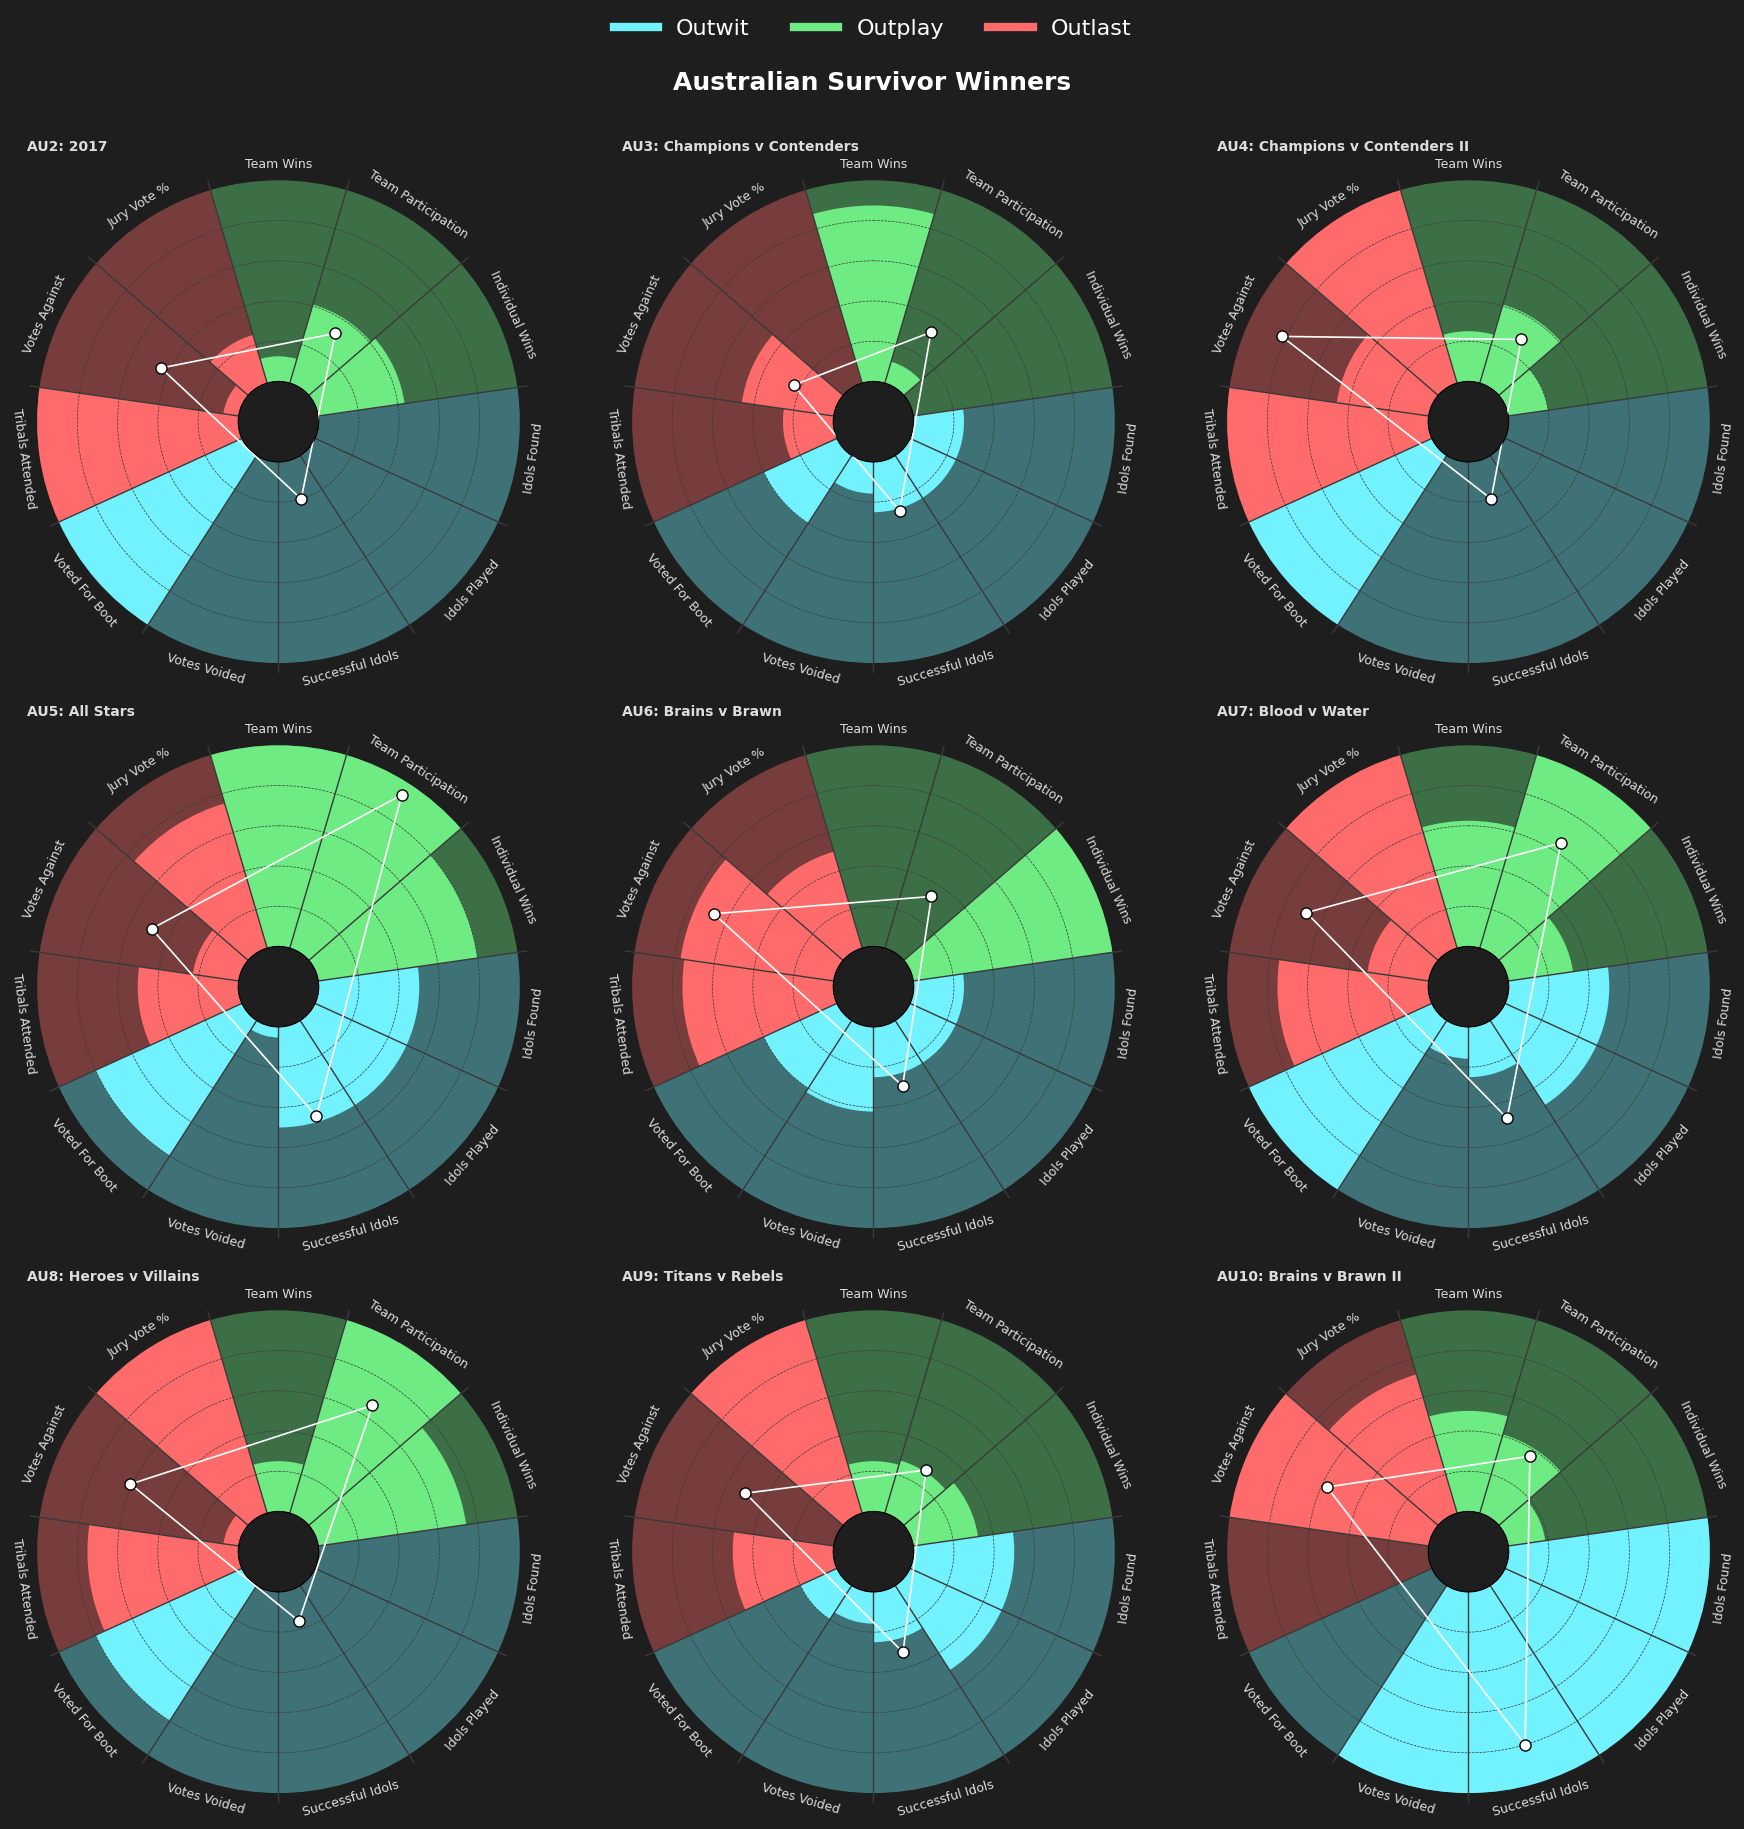

In [99]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from mplsoccer import PyPizza
import matplotlib.pyplot as plt

# === Step 1: Load Data ===
df = pd.read_csv("data.csv")

# === Step 2: Define Metrics & Categories ===
metric_categories = {
    "Team Challenges Won": "Outplay",
    "Team Challenges Played": "Outplay",
    "Ind Challenges Won": "Outplay",

    "Idols Found": "Outwit",
    "Idols Played": "Outwit",
    "Succesful Idols Played": "Outwit",
    "Votes Voided": "Outwit",
    "VFB": "Outwit",

    "Tribals": "Outlast",
    "VAP": "Outlast",
    "Jury Votes Received": "Outlast",
}

# === Step 3: Derived Metrics ===
df["Ind Challenge Win Rate"] = df["Ind Challenges Won"] / df["Ind Challenges Played"].replace(0, 1)
df["Jury Vote %"] = df["Jury Votes Received"] / df["Total Jurors"].replace(0, 1)
team_total = df["Team Challenges Played"] + df["Team Challenges Sat Out"]
df["Team Challenge Participation"] = df["Team Challenges Played"] / team_total.replace(0, 1)

df["Team Challenge Participation"] = df["Team Challenge Participation"].fillna(0)
df["Jury Vote %"] = df["Jury Vote %"].fillna(0)
df["Ind Challenge Win Rate"] = df["Ind Challenge Win Rate"].fillna(0)

# === Step 4: Normalize ===
refined_metrics = [
    "Team Challenges Won",
    "Team Challenge Participation",
    "Ind Challenge Win Rate",
    "Idols Found",
    "Idols Played",
    "Succesful Idols Played",
    "Votes Voided",
    "VFB",
    "Tribals",
    "VAP",
    "Jury Vote %"
]

metric_categories.update({
    "Team Challenge Participation": "Outplay",
    "Ind Challenge Win Rate": "Outplay",
    "Jury Vote %": "Outlast"
})

scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[refined_metrics]), columns=refined_metrics)
df_scaled["Sole Survivor"] = df["Sole Survivor"]

# === Step 5: Melt and Label ===
df_melted = df_scaled.melt(
    id_vars="Sole Survivor",
    var_name="Metric",
    value_name="Normalized Score"
)
df_melted["Category"] = df_melted["Metric"].map(metric_categories)

metric_aliases = {
    "Team Challenges Won": "Team Wins",
    "Team Challenge Participation": "Team Participation",
    "Ind Challenge Win Rate": "Individual Wins",
    "Idols Found": "Idols Found",
    "Idols Played": "Idols Played",
    "Succesful Idols Played": "Successful Idols",
    "Votes Voided": "Votes Voided",
    "VFB": "Voted For Boot",
    "Tribals": "Tribals Attended",
    "VAP": "Votes Against",
    "Jury Vote %": "Jury Vote %"
}

# === Step 6: Plot Single Pizza with Markers and Triangle ===
def plot_pizza(survivor_name, title_by="Season"):
    fig, ax = plt.subplots(figsize=(7,7), subplot_kw={'projection':'polar'})
    fig.patch.set_facecolor('#1E1E1E')  # optional: match your background
    
    data = df_melted[df_melted["Sole Survivor"] == survivor_name]
    params = [metric_aliases.get(m, m) for m in data["Metric"].tolist()]
    values = (data["Normalized Score"] * 100).tolist()
    categories = data["Category"].tolist()
    
    color_map = {
        "Outwit": "#72F1FF",
        "Outplay": "#6EEB83",
        "Outlast": "#FF6B6B"
    }
    slice_colors = [color_map[cat] for cat in categories]

    baker = PyPizza(
        params=params,
        background_color="#1E1E1E",
        straight_line_color="#3A3A3A",
        other_circle_color="#3A3A3A",
        straight_line_lw=1,
        last_circle_lw=0,
        other_circle_lw=0.5,
        inner_circle_size=20,
        max_range=100,
    )

    baker.make_pizza(
        values,
        ax=ax,
        slice_colors=slice_colors,
        value_bck_colors=slice_colors,
        figsize=(7, 7),
        kwargs_values={"fontsize": 0, "color": "none", "visible": False},
        color_blank_space="same",
        value_colors=slice_colors,
        blank_alpha=0.4,
        kwargs_params=dict(color="#DDDDDD", fontsize=9, va="center")
    )
    
    # Determine title text and fontsize
    if title_by.lower() == "season":
        title_text = df.loc[df["Sole Survivor"] == survivor_name, "Season"].values[0]
        title_fontsize = 16
    else:
        title_text = survivor_name
        title_fontsize = 20
    
    plt.subplots_adjust(top=0.85)
    plt.suptitle(title_text, fontsize=title_fontsize, y=0.98, fontweight="bold", color="#FFFFFF")
    
    # Legend at figure level for perfect horizontal alignment with title
    handles = [plt.Line2D([0], [0], color=color_map[cat], lw=6, label=cat) for cat in color_map]
    fig.legend(
        handles=handles,
        loc='upper center',
        bbox_to_anchor=(0.5, 0.94),  # just below the title
        ncol=3,
        frameon=False,
        fontsize=9,
        labelcolor="#FFFFFF",
        bbox_transform=fig.transFigure
    )
    
    # Add Triangle Markers
    subset = df_scaled[df_scaled["Sole Survivor"] == survivor_name]
    outwit_score = subset[["Idols Found", "Idols Played", "Succesful Idols Played", "Votes Voided", "VFB"]].mean(axis=1).values[0] * 100
    outplay_score = subset[["Team Challenges Won", "Team Challenge Participation", "Ind Challenge Win Rate"]].mean(axis=1).values[0] * 100
    outlast_score = subset[["Tribals", "VAP", "Jury Vote %"]].mean(axis=1).values[0] * 100

    marker_mapping = {
        "Team Participation": outplay_score,
        "Successful Idols": outwit_score,
        "Votes Against": outlast_score
    }

    num_slices = len(params)
    marker_points = []

    for metric_label, category_score in marker_mapping.items():
        if metric_label in params:
            idx = params.index(metric_label)
            theta = (2 * np.pi / num_slices) * idx
            r = category_score
            marker_points.append((theta, r))
            ax.plot(theta, r, 'o', markersize=10, color='white', markeredgecolor='white', zorder=10)

    if len(marker_points) == 3:
        marker_points.append(marker_points[0])
        thetas, rs = zip(*marker_points)
        ax.plot(thetas, rs, color='white', linestyle='-', linewidth=1.5, zorder=5)
    
    #plt.savefig("season_09.png", dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())
    plt.show()


# === Step 7: Plot Grid of All Winners ===
def plot_all_pizzas(label_mode='season'):  # default to 'season'
    winners = df_scaled["Sole Survivor"].unique()
    num_winners = len(winners)
    cols = 3
    rows = (num_winners + cols - 1) // cols

    fig, axs = plt.subplots(rows, cols, subplot_kw={'projection': 'polar'}, figsize=(cols * 6, rows * 6))
    axs = axs.flatten()
    fig.patch.set_facecolor('#1E1E1E')
    plt.rcParams['axes.facecolor'] = '#1E1E1E'  # globally set axes facecolor (optional)
    
    color_map = {
        "Outwit": "#72F1FF",   # electric cyan
        "Outplay": "#6EEB83",  # glowing green
        "Outlast": "#FF6B6B"   # coral red
    }

    for idx, winner in enumerate(winners):
        ax = axs[idx]
        ax.set_facecolor("#1E1E1E")  # Set polar subplot background color to match pizza background
        data = df_melted[df_melted["Sole Survivor"] == winner]
        params = [metric_aliases.get(m, m) for m in data["Metric"].tolist()]
        values = (data["Normalized Score"] * 100).tolist()
        categories = data["Category"].tolist()
        slice_colors = [color_map[cat] for cat in categories]
       
        baker = PyPizza(
            params=params,                  # list of parameters
            background_color="#1E1E1E",   # charcoal matte background
            straight_line_color="#3A3A3A",  # darker grid lines
            other_circle_color="#3A3A3A",
            straight_line_lw=1,             # linewidth for straight lines
            last_circle_lw=0,               # linewidth of last circle
            other_circle_lw=0.5,              # linewidth for other circles
            inner_circle_size=20,           # size of inner circle
            max_range=100,
        )

        baker.make_pizza(
            values,
            ax=ax,
            slice_colors=slice_colors,
            value_bck_colors=slice_colors,
            figsize=(7, 7),
            kwargs_values={"fontsize": 0, "color": "none", "visible": False},
            color_blank_space="same",
            value_colors=slice_colors,
            blank_alpha=0.4,
            kwargs_params=dict(
                color="#DDDDDD", fontsize=9, va="center"
            )
        )


        # Triangle markers for all winners
        subset = df_scaled[df_scaled["Sole Survivor"] == winner]
        outwit_score = subset[["Idols Found", "Idols Played", "Succesful Idols Played", "Votes Voided", "VFB"]].mean(axis=1).values[0] * 100
        outplay_score = subset[["Team Challenges Won", "Team Challenge Participation", "Ind Challenge Win Rate"]].mean(axis=1).values[0] * 100
        outlast_score = subset[["Tribals", "VAP", "Jury Vote %"]].mean(axis=1).values[0] * 100

        marker_mapping = {
            "Team Participation": outplay_score,
            "Successful Idols": outwit_score,
            "Votes Against": outlast_score
        }

        num_slices = len(params)
        marker_points = []

        for metric_label, category_score in marker_mapping.items():
            if metric_label in params:
                idx = params.index(metric_label)
                theta = (2 * np.pi / num_slices) * idx
                r = category_score
                marker_points.append((theta, r))
                ax.plot(theta, r, 'o', markersize=8, color='white', markeredgecolor='black', zorder=10)

        if len(marker_points) == 3:
            marker_points.append(marker_points[0])
            thetas, rs = zip(*marker_points)
            ax.plot(thetas, rs, color='white', linestyle='-', linewidth=1.2, zorder=5)

        title_text = df[df["Sole Survivor"] == winner]["Season"].values[0] if label_mode == 'season' else winner
        fontsize = 10 if label_mode == 'season' else 13
        ax.set_title(title_text, fontsize=fontsize, fontweight="bold", color="#DDDDDD", pad=14, loc="left")

    for i in range(len(winners), len(axs)):
        fig.delaxes(axs[i])

    handles = [plt.Line2D([0], [0], color=color_map[cat], lw=6, label=cat) for cat in color_map]
    fig.legend(handles=handles, loc="upper center", bbox_to_anchor=(0.5, 1.02), ncol=3, frameon=False, fontsize=16, labelcolor="#FFFFFF")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.suptitle("Australian Survivor Winners", fontsize=18, fontweight="bold", color="#FFFFFF")
    plt.savefig("winners.png", dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())
    plt.show()
plot_all_pizzas()
    
#plot_pizza("Feras Basal")

In [ ]:
I have the below code - i am really happy with it.

I need two changes.

1. There are some subtly visible lines on each ploit - i believe that these are attached to data labels - we have set the data labels to be transparent so that they  don't show, can we do something similar with these?

2. In the dataset there is a column called Season. I need to have the ability to switch between displayin the winner and the season. The default should be season, though we may need to reduce the font.

Can you help?

Code:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from mplsoccer import PyPizza
import matplotlib.pyplot as plt

# === Step 1: Load Data ===
df = pd.read_csv("data.csv")

# === Step 2: Define Metrics & Categories ===
metric_categories = {
    "Team Challenges Won": "Outplay",
    "Team Challenges Played": "Outplay",
    "Ind Challenges Won": "Outplay",

    "Idols Found": "Outwit",
    "Idols Played": "Outwit",
    "Succesful Idols Played": "Outwit",
    "Votes Voided": "Outwit",
    "VFB": "Outwit",

    "Tribals": "Outlast",
    "VAP": "Outlast",
    "Jury Votes Received": "Outlast",
}

# === Step 3: Derived Metrics ===
df["Ind Challenge Win Rate"] = df["Ind Challenges Won"] / df["Ind Challenges Played"].replace(0, 1)
df["Jury Vote %"] = df["Jury Votes Received"] / df["Total Jurors"].replace(0, 1)
team_total = df["Team Challenges Played"] + df["Team Challenges Sat Out"]
df["Team Challenge Participation"] = df["Team Challenges Played"] / team_total.replace(0, 1)

df["Team Challenge Participation"] = df["Team Challenge Participation"].fillna(0)
df["Jury Vote %"] = df["Jury Vote %"].fillna(0)
df["Ind Challenge Win Rate"] = df["Ind Challenge Win Rate"].fillna(0)

# === Step 4: Normalize ===
refined_metrics = [
    "Team Challenges Won",
    "Team Challenge Participation",
    "Ind Challenge Win Rate",
    "Idols Found",
    "Idols Played",
    "Succesful Idols Played",
    "Votes Voided",
    "VFB",
    "Tribals",
    "VAP",
    "Jury Vote %"
]

metric_categories.update({
    "Team Challenge Participation": "Outplay",
    "Ind Challenge Win Rate": "Outplay",
    "Jury Vote %": "Outlast"
})

scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[refined_metrics]), columns=refined_metrics)
df_scaled["Sole Survivor"] = df["Sole Survivor"]

# === Step 5: Melt and Label ===
df_melted = df_scaled.melt(
    id_vars="Sole Survivor",
    var_name="Metric",
    value_name="Normalized Score"
)
df_melted["Category"] = df_melted["Metric"].map(metric_categories)

metric_aliases = {
    "Team Challenges Won": "Team Wins",
    "Team Challenge Participation": "Team Participation",
    "Ind Challenge Win Rate": "Ind. Win Rate",
    "Idols Found": "Idols Found",
    "Idols Played": "Idols Played",
    "Succesful Idols Played": "Successful Idols",
    "Votes Voided": "Votes Voided",
    "VFB": "Voted For Boot",
    "Tribals": "Tribals Attended",
    "VAP": "Votes Against",
    "Jury Vote %": "Jury Vote %"
}

# === Step 6: Plot Single Pizza with Markers and Triangle ===
def plot_pizza(survivor_name):
    data = df_melted[df_melted["Sole Survivor"] == survivor_name]
    params = [metric_aliases.get(m, m) for m in data["Metric"].tolist()]
    values = (data["Normalized Score"] * 100).tolist()
    categories = data["Category"].tolist()
    
    color_map = {
        "Outwit": "#72F1FF",   # electric cyan
        "Outplay": "#6EEB83",  # glowing green
        "Outlast": "#FF6B6B"   # coral red
    }
    slice_colors = [color_map[cat] for cat in categories]

    baker = PyPizza(
        params=params,                  # list of parameters
        background_color="#1E1E1E",   # charcoal matte background
        straight_line_color="#3A3A3A",  # darker grid lines
        other_circle_color="#3A3A3A",
        straight_line_lw=1,             # linewidth for straight lines
        last_circle_lw=0,               # linewidth of last circle
        other_circle_lw=0.5,              # linewidth for other circles
        inner_circle_size=20,           # size of inner circle
        max_range=100,
    )

    baker.make_pizza(
        values,
        ax=ax,  # 👈 ensure the correct subplot is used
        slice_colors=slice_colors,
        value_bck_colors=slice_colors,
        figsize=(7, 7),
        kwargs_values={"fontsize": 0},
        color_blank_space="same",
        value_colors=slice_colors,
        blank_alpha=0.4,
        kwargs_params=dict(
            color="#DDDDDD", fontsize=9, va="center"
        )
    )

    plt.subplots_adjust(top=0.85)
    plt.suptitle(survivor_name, fontsize=20, y=1.03, fontweight="bold", color="#222222")

    # === Legend ===
    handles = [plt.Line2D([0], [0], color=color_map[cat], lw=6, label=cat) for cat in color_map]
    ax.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, 1.12), ncol=3, frameon=False, fontsize=9)

    # === Add Triangle Markers ===
    subset = df_scaled[df_scaled["Sole Survivor"] == survivor_name]
    outwit_score = subset[["Idols Found", "Idols Played", "Succesful Idols Played", "Votes Voided", "VFB"]].mean(axis=1).values[0] * 100
    outplay_score = subset[["Team Challenges Won", "Team Challenge Participation", "Ind Challenge Win Rate"]].mean(axis=1).values[0] * 100
    outlast_score = subset[["Tribals", "VAP", "Jury Vote %"]].mean(axis=1).values[0] * 100

    marker_mapping = {
        "Team Participation": outplay_score,
        "Successful Idols": outwit_score,
        "Votes Against": outlast_score
    }

    num_slices = len(params)
    marker_points = []

    for metric_label, category_score in marker_mapping.items():
        if metric_label in params:
            idx = params.index(metric_label)
            theta = (2 * np.pi / num_slices) * idx
            r = category_score
            marker_points.append((theta, r))
            ax.plot(theta, r, 'o', markersize=10, color='white', markeredgecolor='black', zorder=10)

    if len(marker_points) == 3:
        marker_points.append(marker_points[0])
        thetas, rs = zip(*marker_points)
        ax.plot(thetas, rs, color='white', linestyle='--', linewidth=1.5, zorder=5)

    plt.show()

# === Step 7: Plot Grid of All Winners ===
def plot_all_pizzas():
    winners = df_scaled["Sole Survivor"].unique()
    num_winners = len(winners)
    cols = 3
    rows = (num_winners + cols - 1) // cols

    fig, axs = plt.subplots(rows, cols, subplot_kw={'projection': 'polar'}, figsize=(cols * 6, rows * 6))
    axs = axs.flatten()
    fig.patch.set_facecolor('#1E1E1E')
    plt.rcParams['axes.facecolor'] = '#1E1E1E'  # globally set axes facecolor (optional)
    
    color_map = {
        "Outwit": "#72F1FF",   # electric cyan
        "Outplay": "#6EEB83",  # glowing green
        "Outlast": "#FF6B6B"   # coral red
    }

    for idx, winner in enumerate(winners):
        ax = axs[idx]
        ax.set_facecolor("#1E1E1E")  # Set polar subplot background color to match pizza background
        data = df_melted[df_melted["Sole Survivor"] == winner]
        params = [metric_aliases.get(m, m) for m in data["Metric"].tolist()]
        values = (data["Normalized Score"] * 100).tolist()
        categories = data["Category"].tolist()
        slice_colors = [color_map[cat] for cat in categories]
       
        baker = PyPizza(
            params=params,                  # list of parameters
            background_color="#1E1E1E",   # charcoal matte background
            straight_line_color="#3A3A3A",  # darker grid lines
            other_circle_color="#3A3A3A",
            straight_line_lw=1,             # linewidth for straight lines
            last_circle_lw=0,               # linewidth of last circle
            other_circle_lw=0.5,              # linewidth for other circles
            inner_circle_size=20,           # size of inner circle
            max_range=100,
        )

        baker.make_pizza(
            values,
            ax=ax,  # 👈 ensure the correct subplot is used
            slice_colors=slice_colors,
            value_bck_colors=slice_colors,
            figsize=(7, 7),
            kwargs_values={"fontsize": 0},
            color_blank_space="same",
            value_colors=slice_colors,
            blank_alpha=0.4,
            kwargs_params=dict(
                color="#DDDDDD", fontsize=9, va="center"
            )
        )

        # Triangle markers for all winners
        subset = df_scaled[df_scaled["Sole Survivor"] == winner]
        outwit_score = subset[["Idols Found", "Idols Played", "Succesful Idols Played", "Votes Voided", "VFB"]].mean(axis=1).values[0] * 100
        outplay_score = subset[["Team Challenges Won", "Team Challenge Participation", "Ind Challenge Win Rate"]].mean(axis=1).values[0] * 100
        outlast_score = subset[["Tribals", "VAP", "Jury Vote %"]].mean(axis=1).values[0] * 100

        marker_mapping = {
            "Team Participation": outplay_score,
            "Successful Idols": outwit_score,
            "Votes Against": outlast_score
        }

        num_slices = len(params)
        marker_points = []

        for metric_label, category_score in marker_mapping.items():
            if metric_label in params:
                idx = params.index(metric_label)
                theta = (2 * np.pi / num_slices) * idx
                r = category_score
                marker_points.append((theta, r))
                ax.plot(theta, r, 'o', markersize=8, color='white', markeredgecolor='black', zorder=10)

        if len(marker_points) == 3:
            marker_points.append(marker_points[0])
            thetas, rs = zip(*marker_points)
            ax.plot(thetas, rs, color='white', linestyle='-', linewidth=1.2, zorder=5)

        ax.set_title(winner, fontsize=13, fontweight="bold", color="#DDDDDD", pad=14, loc="left")

    for i in range(len(winners), len(axs)):
        fig.delaxes(axs[i])

    handles = [plt.Line2D([0], [0], color=color_map[cat], lw=6, label=cat) for cat in color_map]
    fig.legend(handles=handles, loc="upper center", bbox_to_anchor=(0.5, 1.02), ncol=3, frameon=False, fontsize=16, labelcolor="#FFFFFF")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.suptitle("Australian Survivor Winners: Pizza Charts", fontsize=18, fontweight="bold", color="#FFFFFF")
    plt.show()
plot_all_pizzas()